# Veri Yoğun Uygulamalar Modül Projesi: Zaman serisi sınıflandırma problemi

## Amaç:
Milli teknoloji akademisi tarafından Milli Teknoloji Hamlesi altında Yapay Zeka Uzmanlık Programı (YZUP) adıyla bir çok büyük şirketle beraber gerçekleştirilen adlı programda Tübitak'tan Dr. İsmail Güzel'in 18 saatlik Veri Yoğun Uygulamalar egitimi sonunda verdiği projenin çözümü

The solution of the project given by Dr. İsmail Güzel from Tübitak at the end of the 18-hour Data Intensive Applications training in the program called Artificial Intelligence Expertise Program (YZUP) carried out by the Milli Teknoloji Akademisi under the National Technology Move together with many large companies.

Farklı sektörlerden elde edilmiş zaman serileri üzerinden elde edilen feature'lar üzerine kurulmuş bir __classification__ modeli kurarak benzerlik calışması yapmaktır.
### Note:
3 Büyük sektörün hisselerinin sembollerini ve verilerini çekmek adlı başlıktan önceki kodlar hoca tarafından verilmiştir

## Plan:
Finance-Healthcare-Technology sektörleri target class'lar seçilerek modelin bu 3 sektörden alınan veriyle eğitilmesi<br> 
Bu model'i kullanarak bu 3 sektör dışından hisseleri kullanarak modelin gücünün gösterilmesi<br> 
Bu 3 sektör dışındaki sektörler için bu 3 sektörle benzerliklerini gösteren pie-chart'lar hazırlanması

## Yapılması Gerekenler
1 - Sektörlerin listesine ve bu sektörlerdeki hisselerin kodlarına web-scraping kullanarak erişmek (`yfinance`, `investpy`, [`quandl`]((https://docs.data.nasdaq.com/v1.0/docs/python-installation)))<br>
2 - Finance-Healthcare-Technology sektörlerindeki hisselerin 2005-01-01 yılından itibaren verileri çekilerek train veri setini oluşturmak<br>
3 - Veri setinden 4 haftalık momentum gibi feature'lar üretmek. (Train hızına göre 4 haftalık momentum'dan fazlası yapılabilir)<br>
4 - Veri setini eğer boş veri içeriyorsa temizlemek ya da doldurmak, gerekiyorsa encoding, imputing vb. yapmak<br>
5 - Bu işlemler sonucu elde ettiğimiz veri setini tsfresh ile kullanarak feature engineering yapmak<br>
6 - Bu işlem sonucu oluşan yeni veri setimizi temizlemek, düzenlemek (imputing, encoding, transformation vb.)<br>
7 - Modellerimizi eğitmek en iyi hiperparametreleri seçmeye çalışmak<br>
8 - Modelleri karşılaştırmak<br>
9 - Diğer sektörlerden hisseler seçip modelimizin gücünü göstermek<br>
10 - Diğer sektörlerin bu 3 sektöre benzerliklerini gösteren pie-chart hazırlamak(Train ve veri çekmek yeteri kadar hızlı çalışıyorsa)<br>

In [10]:
# Jupyter Notebook'ta birden fazla output'u gösterebilmek için
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# sklearn çıktısını numpy array olarak dönmektedir. Pandas data frame olarak dönmesi için bu değişikliği yapıyorum
from sklearn import set_config
set_config(transform_output="pandas")

import os
if not os.path.exists("data"):
    os.makedirs("data")
    print("'data' klasörü oluşturuldu.")
else:
    print("'data' klasörü zaten var.")

'data' klasörü zaten var.


## Sektörlerin Listesi

In [11]:
import os
import io
import yfinance
import matplotlib.pyplot as plt
import pandas as pd
import requests
from bs4 import BeautifulSoup

def fetch_sectors_names(write_on = False):
    file_name = os.path.join('data', 'sectors_names.csv') 
    if os.path.exists(file_name) and (not write_on):
        df = pd.read_csv(file_name)
    else:
        url = "https://stockanalysis.com/stocks/industry/sectors/"
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            df=pd.read_html(io.StringIO(str(soup.find_all("table"))))[0]
            df.to_csv(file_name, index=False) 
        else:
            print(f"Error: Failed to fetch data from page {url}")
            
    return df

def fetch_industries_names(write_on = False):
    file_name = os.path.join('data', 'industries_names.csv') 
    if os.path.exists(file_name) and (not write_on):
        df = pd.read_csv(file_name)
    else:
        url = "https://stockanalysis.com/stocks/industry/all/"
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            df=pd.read_html(io.StringIO(str(soup.find_all("table"))))[0]
            df.to_csv(file_name, index=False) 
        else:
            print(f"Error: Failed to fetch data from page {url}")
        
    return df

def fetch_data(sector, write_on = False):
    folder_name = os.path.join('data', 'sectors-data')
    file_name = os.path.join(folder_name, f'{sector}_data.csv')
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    if os.path.exists(file_name) and (not write_on):
        df = pd.read_csv(file_name)
    else:
        url = f"https://stockanalysis.com/stocks/sector/{sector}/"
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            df=pd.read_html(io.StringIO(str(soup.find_all("table"))))[0]
            df.drop(columns='No.', inplace=True)
            df.to_csv(file_name, index=False) 
        else:
            print(f"Error: Failed to fetch data from page {url}")
        
    return df

In [12]:
sectors= fetch_sectors_names()
industries= fetch_industries_names()

In [13]:
sectors

,Sector Name,Stocks,Market Cap,Div. Yield,PE Ratio,Profit Margin,1D Change,1Y Change
0,Financials,1384,"9,687.71B",2.41%,14.70,17.75%,-0.05%,11.48%
1,Healthcare,1217,"8,168.30B",0.43%,50.93,4.07%,-0.12%,7.57%
2,Technology,788,17.72T,0.43%,44.88,13.16%,0.32%,15.04%
3,Industrials,652,"5,478.42B",1.10%,26.71,7.32%,0.32%,17.89%
4,Consumer Discretionary,578,"7,264.46B",0.65%,27.33,5.95%,0.04%,2.34%
5,Real Estate,264,"1,506.12B",4.12%,50.70,8.89%,0.98%,7.97%
6,Materials,263,"2,069.57B",1.55%,19.61,8.68%,-0.34%,1.48%
7,Communication Services,260,"5,361.59B",1.08%,28.01,10.40%,-0.12%,2.39%
8,Energy,253,"3,646.12B",2.85%,8.01,12.42%,-0.14%,17.66%
9,Consumer Staples,241,"4,035.50B",1.44%,29.74,4.72%,0.47%,12.92%


## Hisselerin verisini toplamak

In [14]:
csv_file_path = os.path.join('data', 'sectors_names.csv') 
df = pd.read_csv(csv_file_path)

sectors_names = df['Sector Name']

for sector_name in sectors_names:
    formatted_sector_name = sector_name.lower().replace(' ', '-')
    fetch_data(sector=formatted_sector_name)

,Symbol,Company Name,Market Cap,% Change,Volume,Revenue
0,BRK.B,Berkshire Hathaway Inc.,885.23B,-0.11%,701581,439.34B
1,V,Visa Inc.,581.38B,0.80%,712865,33.35B
2,JPM,JPMorgan Chase & Co.,548.13B,0.44%,1576417,158.10B
3,MA,Mastercard Incorporated,443.90B,0.64%,242358,25.10B
4,BAC,Bank of America Corporation,279.41B,0.78%,6532489,98.58B
...,...,...,...,...,...,...
992,NCPL,Netcapital Inc.,1.91M,-1.73%,171573,8.94M
993,TIRX,Tian Ruixiang Holdings Ltd,1.75M,2.96%,2085,1.13M
994,RELI,"Reliance Global Group, Inc.",1.67M,8.23%,52052,14.57M
995,DXF,Dunxin Financial Holdings Limited,1.46M,-0.52%,16328,-2.77M


,Symbol,Company Name,Market Cap,% Change,Volume,Revenue
0,LLY,Eli Lilly and Company,716.59B,1.75%,606658,34.12B
1,NVO,Novo Nordisk A/S,590.69B,0.51%,1259670,34.41B
2,UNH,UnitedHealth Group Incorporated,452.50B,-0.24%,363402,371.62B
3,JNJ,Johnson & Johnson,381.18B,-0.60%,1083754,85.16B
4,ABBV,AbbVie Inc.,314.22B,0.06%,1138495,54.32B
...,...,...,...,...,...,...
1212,MOTS,"Motus GI Holdings, Inc.",977.27K,4.16%,31007,364.00K
1213,REVB,"Revelation Biosciences, Inc.",955.34K,-0.83%,21881,-
1214,NBY,"NovaBay Pharmaceuticals, Inc.",914.10K,-2.00%,221756,14.64M
1215,GRI,"GRI Bio, Inc.",746.78K,-1.95%,70518,-


,Symbol,Company Name,Market Cap,% Change,Volume,Revenue
0,MSFT,Microsoft Corporation,"3,094.18B",0.80%,5255486,227.58B
1,AAPL,Apple Inc,"2,665.58B",2.86%,23972809,385.71B
2,NVDA,NVIDIA Corporation,"2,195.91B",2.65%,20185420,60.92B
3,TSM,Taiwan Semiconductor Manufacturing Company Lim...,710.52B,1.65%,4474504,70.35B
4,AVGO,Broadcom Inc.,572.56B,0.83%,658316,38.87B
...,...,...,...,...,...,...
782,SYTA,Siyata Mobile Inc.,1.69M,-4.39%,1993,8.47M
783,XTKG,X3 Holdings Co Ltd.,1.66M,1.84%,49806,10.05M
784,WISA,"WiSA Technologies, Inc.",1.60M,-1.09%,6715661,2.58M
785,ASTI,"Ascent Solar Technologies, Inc.",1.32M,7.13%,263828,458.26K


,Symbol,Company Name,Market Cap,% Change,Volume,Revenue
0,GE,General Electric Company,184.64B,0.70%,937774,67.95B
1,CAT,Caterpillar Inc.,173.27B,0.80%,396464,67.06B
2,UNP,Union Pacific Corporation,148.87B,-,214174,24.12B
3,UPS,"United Parcel Service, Inc.",130.77B,-0.67%,402006,90.96B
4,HON,Honeywell International Inc.,128.93B,0.45%,200385,36.66B
...,...,...,...,...,...,...
647,STAF,"Staffing 360 Solutions, Inc.",2.36M,0.73%,24202,258.50M
648,RCRT,"Recruiter.com Group, Inc.",2.25M,2.47%,4444,9.94M
649,CISS,C3is Inc.,1.25M,1.06%,37931743,-
650,AULT,"Ault Alliance, Inc.",1.21M,-6.37%,1754831,160.92M


,Symbol,Company Name,Market Cap,% Change,Volume,Revenue
0,AMZN,"Amazon.com, Inc.","1,811.77B",0.95%,8311163,574.79B
1,TSLA,"Tesla, Inc.",520.94B,4.85%,36271745,96.77B
2,HD,"The Home Depot, Inc.",369.88B,0.09%,375191,152.67B
3,TM,Toyota Motor Corporation,316.98B,1.59%,57404,308.27B
4,MCD,McDonald's Corporation,201.55B,-,635436,25.49B
...,...,...,...,...,...,...
573,IVP,"Inspire Veterinary Partners, Inc.",2.47M,-4.80%,1693368,16.07M
574,AUVI,"Applied UV, Inc.",2.02M,-0.25%,11848,37.94M
575,AREB,"American Rebel Holdings, Inc.",1.55M,0.04%,45540,15.27M
576,JFBR,Jeffs' Brands Ltd,1.30M,-15.27%,625397,7.39M


,Symbol,Company Name,Market Cap,% Change,Volume,Revenue
0,PLD,"Prologis, Inc.",119.33B,-0.11%,259060,8.02B
1,AMT,American Tower Corporation,92.03B,-0.13%,216093,11.14B
2,EQIX,"Equinix, Inc.",80.47B,0.61%,38911,8.19B
3,SPG,"Simon Property Group, Inc.",56.51B,0.38%,105308,5.66B
4,WELL,Welltower Inc.,51.97B,0.44%,131594,6.64B
...,...,...,...,...,...,...
256,ALBT,Avalon GloboCare Corp.,3.74M,-1.76%,4614,1.23M
257,VINO,"Gaucho Group Holdings, Inc.",3.56M,1.69%,8663,1.99M
258,DUO,Fangdd Network Group Ltd.,2.12M,-4.91%,115786,35.17M
259,PW,Power REIT,2.03M,-0.33%,1657,4.00M


,Symbol,Company Name,Market Cap,% Change,Volume,Revenue
0,LIN,Linde plc,225.49B,0.95%,476694,32.85B
1,BHP,BHP Group Limited,141.31B,1.04%,564435,55.34B
2,RIO,Rio Tinto Group,100.96B,0.58%,584273,54.04B
3,SHW,The Sherwin-Williams Company,85.04B,0.29%,140239,23.05B
4,SCCO,Southern Copper Corporation,79.63B,0.50%,410799,9.90B
...,...,...,...,...,...,...
257,SNES,"SenesTech, Inc.",3.76M,-1.42%,47429,1.19M
258,YTEN,"Yield10 Bioscience, Inc.",2.89M,8.67%,28224,147.00K
259,RKDA,"Arcadia Biosciences, Inc.",2.83M,-1.58%,2640,5.50M
260,ITP,"IT Tech Packaging, Inc.",2.82M,5.93%,6064,86.96M


,Symbol,Company Name,Market Cap,% Change,Volume,Revenue
0,GOOGL,Alphabet Inc.,"1,760.56B",7.01%,30794045,307.39B
1,META,"Meta Platforms, Inc.","1,234.17B",1.55%,2973720,134.90B
2,NFLX,"Netflix, Inc.",262.20B,2.64%,762498,33.72B
3,DIS,The Walt Disney Company,205.35B,1.20%,2048325,88.94B
4,TMUS,"T-Mobile US, Inc.",192.05B,-0.65%,860150,78.56B
...,...,...,...,...,...,...
255,MGAM,Mobile Global Esports Inc.,4.90M,4.35%,10542,-
256,CSSE,"Chicken Soup for the Soul Entertainment, Inc.",4.74M,1.97%,40030,368.81M
257,TC,TuanChe Limited,2.57M,0.65%,1347,25.71M
258,ONFO,"Onfolio Holdings, Inc.",2.29M,-0.49%,222,5.10M


,Symbol,Company Name,Market Cap,% Change,Volume,Revenue
0,XOM,Exxon Mobil Corporation,441.50B,0.81%,2869012,344.58B
1,CVX,Chevron Corporation,288.90B,0.14%,1517308,200.95B
2,SHEL,Shell plc,212.03B,-0.11%,1125949,323.18B
3,TTE,TotalEnergies SE,159.80B,-0.09%,241936,218.95B
4,COP,Conoco Phillips,141.22B,-0.41%,800457,58.57B
...,...,...,...,...,...,...
247,MTR,Mesa Royalty Trust,19.05M,-5.68%,822,4.13M
248,HUSA,Houston American Energy Corp.,14.51M,-,17616,872.18K
249,MARPS,Marine Petroleum Trust,8.00M,-2.44%,124,1.18M
250,ENSV,Enservco Corporation,5.07M,0.74%,21271,22.08M


,Symbol,Company Name,Market Cap,% Change,Volume,Revenue
0,WMT,Walmart Inc.,488.64B,-,730401,648.13B
1,PG,The Procter & Gamble Company,379.73B,0.61%,1005231,83.93B
2,COST,Costco Wholesale Corporation,321.82B,0.77%,382288,248.83B
3,KO,The Coca-Cola Company,258.23B,0.61%,2214293,45.75B
4,FMX,"Fomento Económico Mexicano, SAB de CV",228.97B,-0.05%,45547,34.56B
...,...,...,...,...,...,...
236,BSFC,Blue Star Foods Corp.,1.89M,-4.87%,1286536,7.17M
237,EAST,"Eastside Distilling, Inc.",1.78M,0.88%,1248,10.81M
238,NUZE,"NuZee, Inc.",1.74M,-,62,3.35M
239,GNLN,"Greenlane Holdings, Inc.",1.64M,14.34%,12034,77.34M


,Symbol,Company Name,Market Cap,% Change,Volume,Revenue
0,NEE,"NextEra Energy, Inc.",123.31B,-0.05%,3605753,28.11B
1,SO,The Southern Company,75.38B,0.35%,423611,25.25B
2,DUK,Duke Energy Corporation,73.00B,-0.17%,469535,29.06B
3,CEG,Constellation Energy Corporation,52.41B,2.43%,310277,24.92B
4,NGG,National Grid plc,50.51B,-0.71%,48907,26.10B
...,...,...,...,...,...,...
103,HTOO,Fusion Fuel Green PLC,25.47M,6.76%,53558,-
104,ADN,"Advent Technologies Holdings, Inc.",13.14M,-,129072,5.31M
105,CREG,Smart Powerr Corp.,10.03M,-0.61%,15017,-
106,WAVE,Eco Wave Power Global AB (publ),6.94M,-1.12%,2690,27.00K


Error: Failed to fetch data from page https://stockanalysis.com/stocks/sector/miscellaneous/


UnboundLocalError: cannot access local variable 'df' where it is not associated with a value

## 3 Büyük sektörün hisselerinin sembollerini ve verilerini çekmek

In [15]:
# Nedense bir tane NaN sembol geldi teknolojide, o yüzden check ediyorum
finance = pd.read_csv('./data/sectors-data/financials_data.csv')
finance_symbols = finance['Symbol'].dropna().tolist()
healthcare = pd.read_csv('./data/sectors-data/healthcare_data.csv')
healthcare_symbols = healthcare['Symbol'].dropna().tolist()
technology = pd.read_csv('./data/sectors-data/technology_data.csv')
technology_symbols = technology['Symbol'].dropna().tolist()
technology_symbols[0:5]

['MSFT', 'AAPL', 'NVDA', 'TSM', 'AVGO']

In [16]:
# +1 sayesinde yüzde 50 düşüş = -0.5 0.5 olur yüzde 50 artış 1.5 olur. 
# Başlangıç fiyatı * 0.5 * 1.5 kaça katlandığını verir
# ffill ile bir ihtimal hisse yanlış, eksik vb. gelirse en yakın öndeki veri ile NaN kısımlarını dolduruyorum
# ffill limit_area = inside diyorum çünkü 
# hisselerin piyasaya 2005 yılında girmemiş ya da günümüzde piyasada olmama ihtimali durumunda oraları doldursun istemiyorum

def get_shares_data(symbols, name, write_on = False):
    folder_name = os.path.join('data', 'shares-data')
    file_name = os.path.join(folder_name, f'{name}_shares_data.csv')
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    if os.path.exists(file_name) and (not write_on):
        shares_data_close = pd.read_csv(file_name, index_col=0)
    else:
        
        shares_data = yfinance.download(symbols, start='2005-01-01', end='2024-01-31').ffill(limit_area="inside")
        shares_data_close = shares_data['Open'].resample('W-MON').last().pct_change(fill_method=None)+1
        # shares_data_close = shares_data_close.fillna(1)
        shares_data_close.to_csv(file_name, index=True) 
        
    return shares_data_close

finance_all_data_close = get_shares_data(finance_symbols, "finance", write_on = False)
healthcare_all_data_close = get_shares_data(healthcare_symbols, "healthcare", write_on = False)
technology_all_data_close = get_shares_data(technology_symbols, "technology", write_on = False)

In [17]:
finance_all_data_close

,AACI,AACT,AAMC,AAME,AB,ABCB,ABL,ABTS,AC,ACAB,...,WU,WULF,XFIN,XP,XYF,YOTA,YRD,ZEO,ZION,ZLS
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-10,NaN,NaN,NaN,1.058632,0.953846,0.902043,NaN,NaN,NaN,NaN,...,NaN,0.923810,NaN,NaN,NaN,NaN,NaN,NaN,0.956586,NaN
2005-01-17,NaN,NaN,NaN,0.972308,1.029777,0.967576,NaN,NaN,NaN,NaN,...,NaN,1.026510,NaN,NaN,NaN,NaN,NaN,NaN,0.981538,NaN
2005-01-24,NaN,NaN,NaN,0.993671,0.992289,1.026596,NaN,NaN,NaN,NaN,...,NaN,0.994261,NaN,NaN,NaN,NaN,NaN,NaN,1.026332,NaN
2005-01-31,NaN,NaN,NaN,0.958599,1.072122,1.041451,NaN,NaN,NaN,NaN,...,NaN,1.010101,NaN,NaN,NaN,NaN,NaN,NaN,1.014814,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-08,1.007428,1.002871,0.916854,1.131222,1.002249,0.948521,1.020690,1.041667,0.971831,1.001890,...,1.002515,0.639344,1.003641,0.961364,1.117808,1.009662,1.297697,1.007105,0.980515,1.000935
2024-01-15,1.004608,0.997137,0.830882,0.992000,1.057692,1.021906,1.100386,0.912000,0.994203,1.075472,...,1.010870,0.943590,1.000093,1.012214,1.031863,1.000000,1.168568,0.994709,0.995432,1.000093
2024-01-22,1.001835,1.004785,1.445428,1.044355,1.018485,1.011008,1.057018,0.912281,0.993586,0.927193,...,1.006617,0.722826,1.002791,0.977812,0.926366,1.012440,0.906724,1.003546,0.964433,1.003644


## 4 Haftalık Momentum hesaplanması

In [18]:
# 4 haftalık momentum bulmak
# Rolling = n büyüklüğünde pencereye bakarak sıradaki işlemi yapması için
# Default parametreler ile işlem yaptığı row pencerenin sağ kenarı olur yani ondan öncekileri alır daha fazlası gerekiyorsa
from sklearn.preprocessing import LabelEncoder
import numpy as np 
def get_rolling_momentum(name, data, n, write_on=False): 
    folder_name = os.path.join('data', 'momentum-data')
    file_name = os.path.join(folder_name, f'{name}_momentum_data.csv')
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    if os.path.exists(file_name) and (not write_on):
        result = pd.read_csv(file_name, index_col=0)
    else:
        result = data.rolling(n).apply(np.prod)
        result.to_csv(file_name, index=True) 
    return result


finance_data_momentum = get_rolling_momentum("finance", finance_all_data_close, 4).replace([np.inf, -np.inf, " "], np.nan)
healthcare_data_momentum = get_rolling_momentum("healthcare", healthcare_all_data_close, 4).replace([np.inf, -np.inf, " "], np.nan)
technology_data_momentum = get_rolling_momentum("technology", technology_all_data_close, 4).replace([np.inf, -np.inf, " "], np.nan)

In [19]:
finance_data_momentum

,AACI,AACT,AAMC,AAME,AB,ABCB,ABL,ABTS,AC,ACAB,...,WU,WULF,XFIN,XP,XYF,YOTA,YRD,ZEO,ZION,ZLS
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-31,NaN,NaN,NaN,0.980456,1.044970,0.933148,NaN,NaN,NaN,NaN,...,NaN,0.952381,NaN,NaN,NaN,NaN,NaN,NaN,0.977925,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-08,1.005561,1.008662,0.585366,1.358696,1.087866,1.079463,1.580232,1.190476,1.028193,0.995305,...,1.004198,1.133721,1.007876,1.071790,1.068063,0.988647,1.332770,1.007105,1.129224,1.004789
2024-01-15,1.014898,0.991461,0.696099,1.305263,1.025800,0.983849,1.398773,1.140000,0.974155,1.068416,...,1.004988,1.088757,1.007498,1.015415,1.169444,1.009662,1.578767,1.002667,0.980869,1.003846
2024-01-22,1.018657,1.000000,1.131640,1.257282,1.085594,1.001914,1.478528,1.083333,0.929877,0.999055,...,1.024411,0.630332,1.006630,0.963190,1.045576,1.022222,1.388704,1.005329,0.949187,1.006560


## Momentum Verisinin outlier ve null değerlerden temizlenmesi

In [20]:
def drop_column_according_to_null_percentage(percentage, data):
    
    null_percentage = data.isnull().mean() * 100
    columns_to_drop = null_percentage[null_percentage >= percentage].index
    dropped_columns_data = data[columns_to_drop]
    data.drop(columns_to_drop, axis=1, inplace=True)
    return dropped_columns_data.copy()

technology_dropped_columns_data = drop_column_according_to_null_percentage(100, technology_data_momentum)
healthcare_dropped_columns_data = drop_column_according_to_null_percentage(100, healthcare_data_momentum)
finance_dropped_columns_data = drop_column_according_to_null_percentage(100, finance_data_momentum)

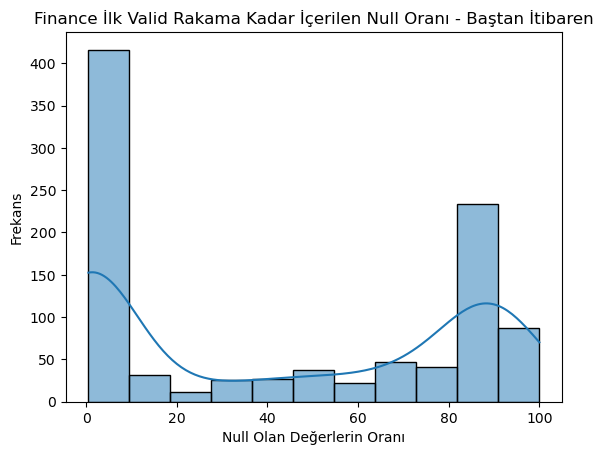

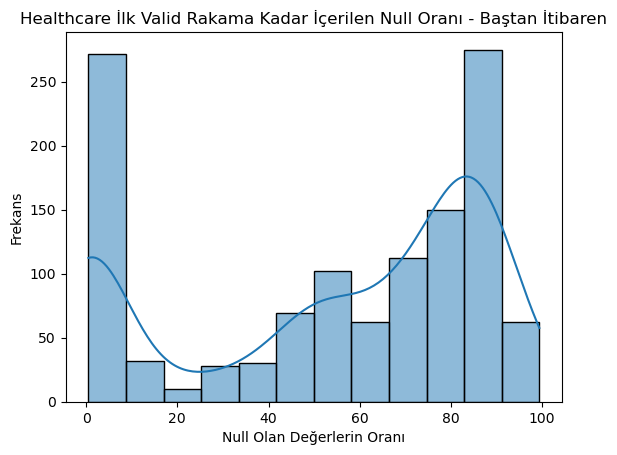

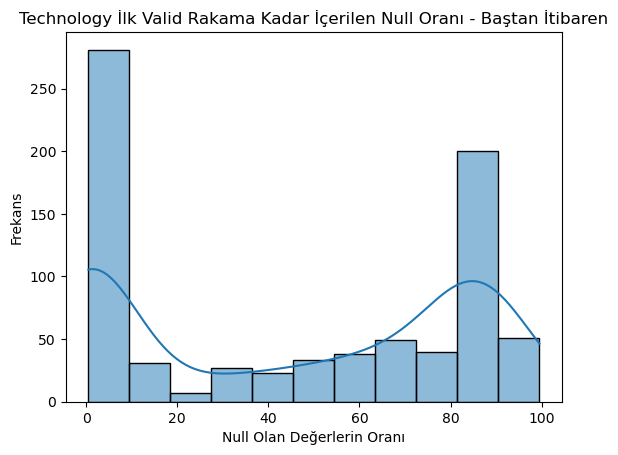

En fazla null içeren column'un null içerme yüzdesi: %0.0
En fazla null içeren column'un null içerme yüzdesi: %0.0
En fazla null içeren column'un null içerme yüzdesi: %0.0


In [21]:
import seaborn as sns
import warnings
# Yukarıda replace([np.inf, -np.inf], np.nan) yapmama rağmen hala uyarı veriyordu
warnings.filterwarnings("ignore", "use_inf_as_na")

def get_start_to_first_not_null_count(name, data):
    null_percentages = {}  
    
    for column in data.columns:
        non_null_index = data[column].first_valid_index()  
        null_count = data.index.get_loc(non_null_index) + 1 if non_null_index is not None else 0  
        total_count = len(data)
        null_percentage = (null_count / total_count) * 100
        null_percentages[column] = null_percentage  
        
    sns.histplot(list(null_percentages.values()), kde=True)
    plt.title(f"{name.capitalize()} İlk Valid Rakama Kadar İçerilen Null Oranı - Baştan İtibaren")
    plt.xlabel("Null Olan Değerlerin Oranı")
    plt.ylabel("Frekans")
    plt.show()
    return null_percentages

finance_non_null_counts = get_start_to_first_not_null_count("finance",finance_data_momentum)
healthcare_non_null_counts = get_start_to_first_not_null_count("healthcare", healthcare_data_momentum)
technology_non_null_counts = get_start_to_first_not_null_count("technology", technology_data_momentum)

def get_end_to_last_not_null_count(name, data):
    null_percentages = {}  
    
    for column in data.columns:
        non_null_index = data[column].last_valid_index()  
        null_count = len(data) - data.index.get_loc(non_null_index) - 1 if non_null_index is not None else 0 
        total_count = len(data)
        null_percentage = (null_count / total_count) * 100
        null_percentages[column] = null_percentage  

    print(f"En fazla null içeren column'un null içerme yüzdesi: %{np.max(null_percentages[column])}")
    return null_percentages
    
finance_non_null_counts_reverse = get_end_to_last_not_null_count("finance", finance_data_momentum)
healthcare_non_null_counts_reverse = get_end_to_last_not_null_count("healthcare", healthcare_data_momentum)
technology_non_null_counts_reverse = get_end_to_last_not_null_count("technology", technology_data_momentum)

In [22]:
# Sonlardaki null değerlerini bırakıyorum çünkü sayıları çok az
# Grafiklerde de gözüktüğü gibi 2005'ten itibaren çok az veri içeren bir çok hisse var
# Bunları azaltmak için belli oranlardan çok null içeren column'ları siliyorum
# Birde çıkardığım column'ları test verisi olarak kullanırım :)
# Test verisi olarak çoğu null olan veriyi kullanmak ne kadar doğru tartışılır :) ama en azından bir test verisi olsun diye
# Label'ı olan test verisi yok demiştiniz derste. ona sahte çözüm buldum :)
# test'ten daha çok validation data gibi. Veri az olduğu için validation data alan modellerde validation data olarak kullanmayı düşünmüyorum

# Kalan hisse sayıları aynı olsun diye oranları böyle seçtim
technology_dropped_columns_data = drop_column_according_to_null_percentage(70, technology_data_momentum)
healthcare_dropped_columns_data = drop_column_according_to_null_percentage(56, healthcare_data_momentum)
finance_dropped_columns_data = drop_column_according_to_null_percentage(46, finance_data_momentum)

In [23]:
technology_data_momentum
healthcare_data_momentum
finance_data_momentum

,AAOI,AAPL,ACIW,ACLS,ACMR,ACN,ADBE,ADEA,ADI,ADSK,...,WNS,WOLF,WYY,XELA,XRX,YEXT,ZBRA,ZEPP,ZS,ZUO
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-31,NaN,1.151281,1.044798,0.901841,NaN,0.953618,0.892064,1.021996,0.948136,0.763185,...,NaN,0.591321,1.026316,NaN,0.925400,NaN,0.890317,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-08,1.015152,0.942934,1.056999,0.956655,1.063433,0.999374,0.920552,1.218971,1.008241,1.028907,...,1.032444,1.029547,1.092233,0.884726,1.083665,0.961199,1.068534,0.986301,1.064378,0.977673
2024-01-15,0.813628,0.948850,1.041317,0.840222,1.140790,1.021421,1.011614,1.024259,0.944295,1.006977,...,1.016646,0.801065,1.186170,0.816327,0.885183,0.992857,0.947316,1.194631,1.042046,0.986143
2024-01-22,0.773295,0.985244,1.004631,0.991683,1.136500,1.040000,1.023635,0.967199,0.991802,1.025683,...,1.050193,0.751622,1.280193,0.680851,0.859342,1.017123,0.944072,1.120567,1.081247,0.948968


,A,ABBV,ABEO,ABIO,ABT,ABUS,ABVC,ACAD,ACB,ACHC,...,XNCR,XOMA,XRAY,XTLB,XTNT,ZBH,ZTEK,ZTS,ZVRA,ZYXI
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-31,0.910373,NaN,0.772222,0.808809,0.973548,NaN,1.000000,1.048387,NaN,1.092199,...,NaN,0.763359,1.009919,NaN,NaN,0.996635,NaN,NaN,NaN,0.966666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-08,1.019746,1.076392,1.178571,0.921348,1.066404,1.214634,1.161017,1.417572,0.917308,1.065456,...,1.007367,1.334180,1.113486,0.961538,0.884615,1.029530,1.187500,1.050548,1.181818,1.254042
2024-01-15,0.947089,1.063725,1.088477,0.937143,1.060665,1.071429,1.114504,1.022807,0.937500,1.118584,...,0.996145,1.337580,1.067171,0.896907,1.064220,1.040811,1.314286,0.999343,1.289641,1.058300
2024-01-22,0.941910,1.072738,1.062500,0.935673,1.055760,1.052863,1.128440,0.910631,0.884861,1.122677,...,0.955491,1.089994,1.020176,1.118421,0.946429,1.028180,1.094340,0.973326,1.169734,0.965258


,AAME,AB,ABCB,ACGL,ACIC,ACNB,AEG,AEL,AFG,AFL,...,WSBF,WSFS,WT,WTBA,WTFC,WTM,WTW,WU,WULF,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-31,0.980456,1.044970,0.933148,0.960779,NaN,1.001934,0.986861,0.969416,0.956314,0.979073,...,NaN,0.947798,1.063584,1.001113,0.966667,0.912152,0.927419,NaN,0.952381,0.977925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-08,1.358696,1.087866,1.079463,0.972520,1.164949,1.128032,1.030357,1.000724,1.044634,0.997703,...,1.085625,1.071687,1.061633,1.067504,1.008128,0.994606,0.986947,1.004198,1.133721,1.129224
2024-01-15,1.305263,1.025800,0.983849,1.037922,1.158803,0.932627,1.014035,0.999100,1.008870,1.024209,...,0.991311,0.985185,1.102964,0.942937,1.015643,1.039703,1.040995,1.004988,1.088757,0.980869
2024-01-22,1.257282,1.085594,1.001914,1.091485,1.270300,0.992282,1.043630,1.000000,1.004537,1.036683,...,0.944134,0.979927,1.105341,0.951208,1.062975,1.177286,1.049726,1.024411,0.630332,0.949187


In [24]:
# Null verilerden veriyi kurtarmak
from sklearn.impute import SimpleImputer

def clear_the_null(imputer, data):
    imputer.fit(data)
    imputed_data = imputer.transform(data)
    return imputed_data


# median kullanıyorum çünkü outlier'lar eğer varsa az etkilensin istiyorum
# Test verisine aynı imputer'ı vurunca %46-%70 fazla null olduğu için sorun olma ihtimali yüksek
# Test verisini merağımdan koyduğumdan ona göre değiştirmeyeceğim ama, çünkü bence finance 4 haftalık momentum için median daha uygun
# IterativeImputer gibi teknikleri düşündüm ama feature olarak günleri almam gerekiyordu bence (test verisine uygulayabilmek için), öyle yapmak istemedim
imputer = SimpleImputer(strategy='median')

# Train verisi
imputed_technology_data = clear_the_null(imputer, technology_data_momentum)
imputed_finance_data = clear_the_null(imputer, finance_data_momentum)
imputed_healthcare_data = clear_the_null(imputer, healthcare_data_momentum) 

# Test verisi 
imputed_dropped_technology_data = clear_the_null(imputer, technology_dropped_columns_data)
imputed_dropped_finance_data = clear_the_null(imputer, finance_dropped_columns_data)
imputed_dropped_healthcare_data = clear_the_null(imputer, healthcare_dropped_columns_data) 

technology_data_momentum.head(6)
imputed_technology_data.head(6)

,AAOI,AAPL,ACIW,ACLS,ACMR,ACN,ADBE,ADEA,ADI,ADSK,...,WNS,WOLF,WYY,XELA,XRX,YEXT,ZBRA,ZEPP,ZS,ZUO
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-31,NaN,1.151281,1.044798,0.901841,NaN,0.953618,0.892064,1.021996,0.948136,0.763185,...,NaN,0.591321,1.026316,NaN,0.925400,NaN,0.890317,NaN,NaN,NaN
2005-02-07,NaN,1.130317,1.183389,1.233728,NaN,0.959475,1.087585,1.113823,1.062287,0.921965,...,NaN,0.708898,1.125000,NaN,0.955473,NaN,0.969292,NaN,NaN,NaN


,AAOI,AAPL,ACIW,ACLS,ACMR,ACN,ADBE,ADEA,ADI,ADSK,...,WNS,WOLF,WYY,XELA,XRX,YEXT,ZBRA,ZEPP,ZS,ZUO
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,0.978378,1.028584,1.010050,1.011628,1.019914,1.017619,1.023275,1.010812,1.008241,1.017096,...,1.011897,1.007104,0.987805,0.984746,1.005063,0.999196,1.015413,0.979686,1.042138,0.988937
2005-01-10,0.978378,1.028584,1.010050,1.011628,1.019914,1.017619,1.023275,1.010812,1.008241,1.017096,...,1.011897,1.007104,0.987805,0.984746,1.005063,0.999196,1.015413,0.979686,1.042138,0.988937
2005-01-17,0.978378,1.028584,1.010050,1.011628,1.019914,1.017619,1.023275,1.010812,1.008241,1.017096,...,1.011897,1.007104,0.987805,0.984746,1.005063,0.999196,1.015413,0.979686,1.042138,0.988937
2005-01-24,0.978378,1.028584,1.010050,1.011628,1.019914,1.017619,1.023275,1.010812,1.008241,1.017096,...,1.011897,1.007104,0.987805,0.984746,1.005063,0.999196,1.015413,0.979686,1.042138,0.988937
2005-01-31,0.978378,1.151281,1.044798,0.901841,1.019914,0.953618,0.892064,1.021996,0.948136,0.763185,...,1.011897,0.591321,1.026316,0.984746,0.925400,0.999196,0.890317,0.979686,1.042138,0.988937
2005-02-07,0.978378,1.130317,1.183389,1.233728,1.019914,0.959475,1.087585,1.113823,1.062287,0.921965,...,1.011897,0.708898,1.125000,0.984746,0.955473,0.999196,0.969292,0.979686,1.042138,0.988937


## Outlier Temizliği

In [25]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
# Her sektörün kendi içinde aykırı olan günlerini (4 hafta aslında) aradım
# Aykırı hisse aranması da yapılıp onlar doğrudan çıkarılabilir ama ben yapmadım bunu
def find_outliers(name, model, data, write_on=False):
    folder_name = os.path.join('data', 'outliers-indexes')
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    file_name = os.path.join(folder_name, f'{name}_outliers-indexes.csv')
    if os.path.exists(file_name) and (not write_on):
        outliers_index = pd.read_csv(file_name)
    else:
        outliers_index = model.fit_predict(data.mean(axis=1).values.reshape(-1, 1))
        outliers_index = pd.DataFrame(outliers_index)
        outliers_index.to_csv(file_name, index=False) 
    outliers_index = outliers_index.values.flatten()
    print(f"{name} Aykırı Veri Sayısı: {np.sum(outliers_index == -1)}")
    print(len(outliers_index))
    print(data.shape)
    return outliers_index

outlier_ISO = IsolationForest(contamination='auto')
outlier_LOF = LocalOutlierFactor(n_neighbors=25)
outlier_ee = EllipticEnvelope(contamination=0.05, support_fraction=1)
technology_outliers_indexes = find_outliers("Technology", outlier_LOF, imputed_technology_data) 
finance_outliers_indexes = find_outliers("Finance", outlier_LOF, imputed_finance_data) 
healthcare_outliers_indexes = find_outliers("Healthcare", outlier_LOF, imputed_healthcare_data) 

Technology Aykırı Veri Sayısı: 19
997
(997, 469)
Finance Aykırı Veri Sayısı: 32
997
(997, 512)
Healthcare Aykırı Veri Sayısı: 21
997
(997, 524)


Şimdi bu çıkan sonuç ilk başta beni şaşırtsa da az olmasıyla, aslında 4 haftalık momentum aldığımızdan finans alanında 4 haftalık dönemde aykırı değer olmasının çok düşük ihtimal olmasından kaynaklı olduğunu düşünüyorum (en azından baktığımız hisselerin gücü düşünülünce)

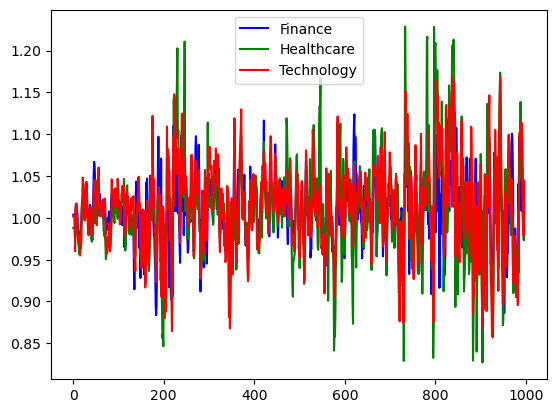

In [26]:
# Recode tekniği ile aykırı değerlerden kurtuluyorum

imputed_technology_data.iloc[technology_outliers_indexes == -1, :] = None
imputed_finance_data.iloc[finance_outliers_indexes == -1, :] = None
imputed_healthcare_data.iloc[healthcare_outliers_indexes == -1, :] = None

# Outlier'lar için olduğundan test verisini düşünmem gerekmiyor, o yüzden denemek istedim
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=15)


clean_technology_data = clear_the_null(imputer, imputed_technology_data)
clean_finance_data = clear_the_null(imputer, imputed_finance_data)
clean_healthcare_data = clear_the_null(imputer, imputed_healthcare_data)

# Hisseleri sektörlerle karşılaştırmak için bu kopyaları kullanmayı planlıyorum notebook'un sonuna doğru
clean_technology_data_copy = clean_technology_data.copy()
clean_finance_data_copy = clean_finance_data.copy()
clean_healthcare_data_copy = clean_healthcare_data.copy()

#clean_healthcare_data.iloc[healthcare_outliers_indexes == -1, :].head()

finance_mean = clean_finance_data_copy.mean(axis=1)
healthcare_mean = clean_healthcare_data_copy.mean(axis=1)
technology_mean = clean_technology_data_copy.mean(axis=1)
plt.plot(finance_mean.values, label='Finance', color='blue')
plt.plot(healthcare_mean.values, label='Healthcare', color='green')
plt.plot(technology_mean.values, label='Technology', color='red')
plt.legend()
plt.show()

## tsfresh ile Feature Extraction 

In [27]:
# İlk öncelikle isimler çok karışmaya başladığından dolayı veri setlerini topluyorum.

# Symbol'leri çıkarıyorum birleştirmeden önce label oluşturabilmek için sonradan
clean_technology_symbols = technology_data_momentum.columns.copy()
clean_finance_symbols = finance_data_momentum.columns.copy()
clean_healthcare_symbols = healthcare_data_momentum.columns.copy()

clean_technology_test_symbols = imputed_dropped_technology_data.columns.copy()
clean_finance_test_symbols = imputed_dropped_finance_data.columns.copy()
clean_healthcare_test_symbols = imputed_dropped_healthcare_data.columns.copy()

clean_train_data = pd.concat([clean_technology_data, clean_finance_data, clean_healthcare_data], axis=1)
clean_test_data = pd.concat([imputed_dropped_technology_data, imputed_dropped_finance_data, imputed_dropped_healthcare_data], axis=1)

In [28]:
clean_train_data.shape
clean_test_data.shape
clean_train_data.head()

(997, 1505)

(997, 1459)

,AAOI,AAPL,ACIW,ACLS,ACMR,ACN,ADBE,ADEA,ADI,ADSK,...,XNCR,XOMA,XRAY,XTLB,XTNT,ZBH,ZTEK,ZTS,ZVRA,ZYXI
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,0.978378,1.028584,1.010050,1.011628,1.019914,1.017619,1.023275,1.010812,1.008241,1.017096,...,0.999007,0.982143,1.003470,0.973799,0.964781,1.007999,0.968944,1.011249,0.986928,1.000000
2005-01-10,0.978378,1.028584,1.010050,1.011628,1.019914,1.017619,1.023275,1.010812,1.008241,1.017096,...,0.999007,0.982143,1.003470,0.973799,0.964781,1.007999,0.968944,1.011249,0.986928,1.000000
2005-01-17,0.978378,1.028584,1.010050,1.011628,1.019914,1.017619,1.023275,1.010812,1.008241,1.017096,...,0.999007,0.982143,1.003470,0.973799,0.964781,1.007999,0.968944,1.011249,0.986928,1.000000
2005-01-24,0.978378,1.028584,1.010050,1.011628,1.019914,1.017619,1.023275,1.010812,1.008241,1.017096,...,0.999007,0.982143,1.003470,0.973799,0.964781,1.007999,0.968944,1.011249,0.986928,1.000000
2005-01-31,0.978378,1.151281,1.044798,0.901841,1.019914,0.953618,0.892064,1.021996,0.948136,0.763185,...,0.999007,0.763359,1.009919,0.973799,0.964781,0.996635,0.968944,1.011249,0.986928,0.966666


In [29]:
def readying_for_tsfresh(name, data, write_on=False):
    folder_name = os.path.join('data', 'before-tsfresh')
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    file_name = os.path.join(folder_name, f'{name}_before-tsfresh.csv')
    if os.path.exists(file_name) and (not write_on):
        stacked_data = pd.read_csv(file_name)
    else:
        stacked_data = data.stack().reset_index() 
        stacked_data.columns = ['Date', 'id', 'Momentum(3M)']   
        stacked_data.sort_values(by=['id', 'Date'], inplace=True)
        stacked_data.reset_index(drop=True, inplace=True)
        stacked_data.to_csv(file_name, index=False) 
    return stacked_data

test_data = readying_for_tsfresh("test", clean_test_data)
train_data = readying_for_tsfresh("train", clean_train_data)

train_data

,Date,id,Momentum(3M)
0,2005-01-03,A,1.015404
1,2005-01-10,A,1.015404
2,2005-01-17,A,1.015404
3,2005-01-24,A,1.015404
4,2005-01-31,A,0.910373
...,...,...,...
1500480,2024-01-08,ZYXI,1.254042
1500481,2024-01-15,ZYXI,1.058300
1500482,2024-01-22,ZYXI,0.965258
1500483,2024-01-29,ZYXI,1.043199


Veriyi tsfresh'e verene kadar scaling yapmadım çünkü <br>
1 - İhtiyaç olduğunu düşünmüyorum 4 haftalık momentum kullandığımızdan ama asıl sebep<br>
2 - outlier'lara karşı robustScaler kullanmayı düşündüm ama veri kaybı olma ihtimali var, 1 numarada yazdığımından dolayı gerek olduğunu da 
düşünmediğimden yapmadım <br>
3 - Özellikle robustScaler sonucu bazı verilerin yüksek oranda negatif olma ihtimali var. Bu da aradaki oranları tamamıyla bozabilir.

In [30]:
import tsfresh
# Sadece momentum verisi olmasa 
# https://tsfresh.readthedocs.io/en/v0.20.2/text/data_formats.html
# Buradaki Stacked DataFrame'e benzer haline getirip öyle kullanmalıydık
# https://tsfresh.readthedocs.io/en/v0.20.2/_modules/tsfresh/utilities/dataframe_functions.html
# https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_selection.html
# Kolaay yolu yapmadım ödevde bunun istenmediğini düşündüğümden
"""
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

impute(extracted_features)
features_filtered = select_features(extracted_features, y)
"""
def extract_features(name, data, column_id, column_sort, write_on=False):
    folder_name = os.path.join('data', 'raw-tsfresh-data')
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    file_name = os.path.join(folder_name, f'{name}-raw-tsfresh-data.csv')
    if os.path.exists(file_name) and (not write_on):
        features = pd.read_csv(file_name, index_col=0)
    else:
        features = tsfresh.extract_features(data, column_id=column_id, column_sort=column_sort, 
                                           default_fc_parameters=tsfresh.feature_extraction.ComprehensiveFCParameters())
        features.to_csv(file_name, index=True) 
    return features
    
train_features = extract_features("train", train_data, "id", "Date")
test_features = extract_features("test", test_data, "id", "Date")
train_features.columns
len(train_features.columns)
len(test_features.columns)

'\nfrom tsfresh import select_features\nfrom tsfresh.utilities.dataframe_functions import impute\n\nimpute(extracted_features)\nfeatures_filtered = select_features(extracted_features, y)\n'

Index(['Momentum(3M)__variance_larger_than_standard_deviation',
       'Momentum(3M)__has_duplicate_max', 'Momentum(3M)__has_duplicate_min',
       'Momentum(3M)__has_duplicate', 'Momentum(3M)__sum_values',
       'Momentum(3M)__abs_energy', 'Momentum(3M)__mean_abs_change',
       'Momentum(3M)__mean_change',
       'Momentum(3M)__mean_second_derivative_central', 'Momentum(3M)__median',
       ...
       'Momentum(3M)__fourier_entropy__bins_5',
       'Momentum(3M)__fourier_entropy__bins_10',
       'Momentum(3M)__fourier_entropy__bins_100',
       'Momentum(3M)__permutation_entropy__dimension_3__tau_1',
       'Momentum(3M)__permutation_entropy__dimension_4__tau_1',
       'Momentum(3M)__permutation_entropy__dimension_5__tau_1',
       'Momentum(3M)__permutation_entropy__dimension_6__tau_1',
       'Momentum(3M)__permutation_entropy__dimension_7__tau_1',
       'Momentum(3M)__query_similarity_count__query_None__threshold_0.0',
       'Momentum(3M)__mean_n_absolute_max__number_of_maxim

783

783

## tsfresh Verisinin Temizliği

In [31]:
train_features.head()

,Momentum(3M)__variance_larger_than_standard_deviation,Momentum(3M)__has_duplicate_max,Momentum(3M)__has_duplicate_min,Momentum(3M)__has_duplicate,Momentum(3M)__sum_values,Momentum(3M)__abs_energy,Momentum(3M)__mean_abs_change,Momentum(3M)__mean_change,Momentum(3M)__mean_second_derivative_central,Momentum(3M)__median,...,Momentum(3M)__fourier_entropy__bins_5,Momentum(3M)__fourier_entropy__bins_10,Momentum(3M)__fourier_entropy__bins_100,Momentum(3M)__permutation_entropy__dimension_3__tau_1,Momentum(3M)__permutation_entropy__dimension_4__tau_1,Momentum(3M)__permutation_entropy__dimension_5__tau_1,Momentum(3M)__permutation_entropy__dimension_6__tau_1,Momentum(3M)__permutation_entropy__dimension_7__tau_1,Momentum(3M)__query_similarity_count__query_None__threshold_0.0,Momentum(3M)__mean_n_absolute_max__number_of_maxima_7
A,0.0,0.0,0.0,1.0,1009.079162,1027.176052,0.041252,0.000005,0.000037,1.014692,...,0.877976,1.280384,3.048845,1.720658,2.957948,4.314386,5.496994,6.320189,NaN,1.250557
AAME,0.0,0.0,0.0,1.0,1006.029297,1032.477281,0.069615,0.000096,-0.000036,1.000000,...,0.834680,1.338419,3.206330,1.760831,3.079340,4.537013,5.834188,6.551508,NaN,1.900124
AAOI,0.0,0.0,0.0,1.0,1004.977523,1051.918547,0.064639,-0.000126,0.000082,0.978378,...,0.794703,1.063050,2.770406,1.297971,2.103573,2.903932,3.555866,3.960537,NaN,2.329726
AAPL,0.0,0.0,0.0,1.0,1023.002510,1056.950123,0.047548,0.000020,0.000029,1.027687,...,0.767966,1.150776,2.857411,1.728803,2.977838,4.344839,5.574364,6.402238,NaN,1.273416
AB,0.0,0.0,0.0,1.0,1003.279171,1016.279390,0.047144,0.000062,-0.000007,1.006298,...,0.766147,1.173830,2.976913,1.728062,2.965883,4.314019,5.542601,6.366548,NaN,1.268775


In [32]:
def data_type_setup(data):
    # np.inf değerlerinden kurtulmak
    max_values = data.apply(lambda x: np.max(x[np.isfinite(x)]))
    data.replace(np.inf, max_values, inplace=True)
    # -np.inf değerlerinden kurtulmak
    min_values = data.apply(lambda x: np.min(x[np.isfinite(x)]))
    data.replace(-np.inf, min_values, inplace=True)
    # Boş değerlere np.nan değerini yazmak
    data.replace([" "], np.nan, inplace=True)

data_type_setup(train_features)
data_type_setup(test_features)

# Null değerlerden kurtulmak, %30'dan fazlası null olan column'ları siliyorum
null_percentages = train_features.isnull().mean()
columns_to_drop_after_tsfresh = null_percentages[(null_percentages > 0.3)].index
train_features.drop(columns=columns_to_drop_after_tsfresh, inplace=True)

# Bu train verisinden öğrenilen bir bilgi olduğundan test'e doğrudan uyguluyorum
test_features.drop(columns=columns_to_drop_after_tsfresh, inplace=True)
train_features.columns

Index(['Momentum(3M)__variance_larger_than_standard_deviation',
       'Momentum(3M)__has_duplicate_max', 'Momentum(3M)__has_duplicate_min',
       'Momentum(3M)__has_duplicate', 'Momentum(3M)__sum_values',
       'Momentum(3M)__abs_energy', 'Momentum(3M)__mean_abs_change',
       'Momentum(3M)__mean_change',
       'Momentum(3M)__mean_second_derivative_central', 'Momentum(3M)__median',
       ...
       'Momentum(3M)__fourier_entropy__bins_3',
       'Momentum(3M)__fourier_entropy__bins_5',
       'Momentum(3M)__fourier_entropy__bins_10',
       'Momentum(3M)__fourier_entropy__bins_100',
       'Momentum(3M)__permutation_entropy__dimension_3__tau_1',
       'Momentum(3M)__permutation_entropy__dimension_4__tau_1',
       'Momentum(3M)__permutation_entropy__dimension_5__tau_1',
       'Momentum(3M)__permutation_entropy__dimension_6__tau_1',
       'Momentum(3M)__permutation_entropy__dimension_7__tau_1',
       'Momentum(3M)__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object

In [33]:
# unique sayısı 1 olan yani sürekli aynı veriye sahip olan column'ları temizliyorum
non_unique_columns = train_features.columns[train_features.nunique(dropna=True) <= 1]
train_features.drop(columns=non_unique_columns, inplace=True)

# Bu train verisinden öğrenilen bir bilgi olduğundan test'e doğrudan uyguluyorum
test_features.drop(columns=non_unique_columns, inplace=True)
train_features.columns

Index(['Momentum(3M)__variance_larger_than_standard_deviation',
       'Momentum(3M)__has_duplicate_max', 'Momentum(3M)__has_duplicate_min',
       'Momentum(3M)__sum_values', 'Momentum(3M)__abs_energy',
       'Momentum(3M)__mean_abs_change', 'Momentum(3M)__mean_change',
       'Momentum(3M)__mean_second_derivative_central', 'Momentum(3M)__median',
       'Momentum(3M)__mean',
       ...
       'Momentum(3M)__fourier_entropy__bins_3',
       'Momentum(3M)__fourier_entropy__bins_5',
       'Momentum(3M)__fourier_entropy__bins_10',
       'Momentum(3M)__fourier_entropy__bins_100',
       'Momentum(3M)__permutation_entropy__dimension_3__tau_1',
       'Momentum(3M)__permutation_entropy__dimension_4__tau_1',
       'Momentum(3M)__permutation_entropy__dimension_5__tau_1',
       'Momentum(3M)__permutation_entropy__dimension_6__tau_1',
       'Momentum(3M)__permutation_entropy__dimension_7__tau_1',
       'Momentum(3M)__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length

In [34]:
from numpy import dtype
(train_features.dtypes != dtype('float64')).sum() 
# Tüm veri float64 yani character içeren bir veri yok

0

## Null temizliği

In [35]:
# Null değerlerden kurtulmak için MICE kullanıyordum ama tüm verinin bir arada olmasından dolayı vazgeçtim
# önerdiğiniz Class bazlı MICE yöntemini denemek isterdim ama zamanım az kaldı
# en basitinden veriyi sektör sektör bölüp MICE uygulayabilirdim ama o zaman da test verisine bunu nasıl fit edecektim sorusuna cevap bulamadım
# başka sektördeki veriden bilgi alma ihtimali var
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import BayesianRidge
import pickle

def train_simple_imputer(data, write_on=False):
    folder_name = os.path.join('data', 'models')
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    file_name = os.path.join(folder_name, 'simple_imputer.pkl')
    if os.path.exists(file_name) and (not write_on):
        with open(file_name, "rb") as model_file:
            simple_imputer = pickle.load(model_file)
    else:
        #iterative_imputer = IterativeImputer(estimator=BayesianRidge(), initial_strategy='median', random_state=61)
        simple_imputer = SimpleImputer(strategy='most_frequent')
        simple_imputer.fit(data)
        with open(file_name, "wb") as model_file:
            pickle.dump(simple_imputer, model_file)
    return simple_imputer

simple_imputer = train_simple_imputer(train_features)
train_features = simple_imputer.transform(train_features)

# Bu train verisinden öğrenilen bir bilgi olduğundan test'e doğrudan uyguluyorum
test_features = simple_imputer.transform(test_features)

## Outlier Temizliği

In [36]:
#Sektör sektör outlier arıyorum
technology_train = train_features.loc[train_features.index.isin(clean_technology_symbols)]
finance_train = train_features.loc[train_features.index.isin(clean_finance_symbols)]
healthcare_train = train_features.loc[train_features.index.isin(clean_healthcare_symbols)]

outlier_ISO = IsolationForest(contamination='auto')
finance_train_outliers_indexes_ISO = find_outliers("Finance_Train_ISO", outlier_ISO, finance_train) 
technology_train_outliers_indexes_ISO = find_outliers("Technology_Train_ISO", outlier_ISO, technology_train) 
healthcare_train_outliers_indexes_ISO = find_outliers("Healthcare_Train_ISO", outlier_ISO, healthcare_train) 

outlier_LOF = LocalOutlierFactor()
finance_train_outliers_indexes_LOF = find_outliers("Finance_Train_LOF", outlier_LOF, finance_train) 
technology_train_outliers_indexes_LOF = find_outliers("Technology_Train_LOF", outlier_LOF, technology_train) 
healthcare_train_outliers_indexes_LOF = find_outliers("Healthcare_Train_LOF", outlier_LOF, healthcare_train) 

#İki farklı tekniğin keşişimlerini alarak doğruluğu yükseltmeye uğraşıyorum
finance_train_outliers_indexes = finance_train_outliers_indexes_ISO + finance_train_outliers_indexes_LOF
print(f"Finans Sektöründe Aykırı Hisse Sayısı: {np.sum(finance_train_outliers_indexes == -2)}")

technology_train_outliers_indexes = technology_train_outliers_indexes_ISO + technology_train_outliers_indexes_LOF
print(f"Teknoloji Sektöründe Aykırı Hisse Sayısı: {np.sum(technology_train_outliers_indexes == -2)}")

healthcare_train_outliers_indexes = healthcare_train_outliers_indexes_ISO + healthcare_train_outliers_indexes_LOF
print(f"Sağlık Sektöründe Aykırı Hisse Sayısı: {np.sum(healthcare_train_outliers_indexes == -2)}")

imputer = SimpleImputer(strategy='median')
finance_train.iloc[finance_train_outliers_indexes == -2, :] = None
finance_train = clear_the_null(imputer, finance_train)

healthcare_train.iloc[healthcare_train_outliers_indexes == -2, :] = None
healthcare_train = clear_the_null(imputer, healthcare_train)

technology_train.iloc[technology_train_outliers_indexes == -2, :] = None
technology_train = clear_the_null(imputer, technology_train)

train_features = pd.concat([healthcare_train, finance_train, technology_train], ignore_index=False)
train_features.sort_index(inplace=True)

Finance_Train_ISO Aykırı Veri Sayısı: 95
512
(512, 728)
Technology_Train_ISO Aykırı Veri Sayısı: 82
469
(469, 728)
Healthcare_Train_ISO Aykırı Veri Sayısı: 59
524
(524, 728)
Finance_Train_LOF Aykırı Veri Sayısı: 23
512
(512, 728)
Technology_Train_LOF Aykırı Veri Sayısı: 29
469
(469, 728)
Healthcare_Train_LOF Aykırı Veri Sayısı: 27
524
(524, 728)
Finans Sektöründe Aykırı Hisse Sayısı: 23
Teknoloji Sektöründe Aykırı Hisse Sayısı: 29
Sağlık Sektöründe Aykırı Hisse Sayısı: 27


In [37]:
from sklearn.preprocessing import RobustScaler
# Scaling, robust scaler

robust_scaler = RobustScaler()
robust_scaler.fit(train_features)
train_features = robust_scaler.transform(train_features)

# Bu train verisinden öğrenilen bir bilgi olduğundan test'e doğrudan uyguluyorum
test_features = robust_scaler.transform(test_features)

RobustScaler()

In [38]:
# Varsa duplicate feature'ları düşürmek için
from feature_engine.selection import DropDuplicateFeatures
selector_drop_duplicate = DropDuplicateFeatures()
selector_drop_duplicate.fit(train_features)
train_features = selector_drop_duplicate.transform(train_features)
test_features = selector_drop_duplicate.transform(test_features)
train_features.shape

DropDuplicateFeatures()

(1505, 725)

In [39]:
train_features.head()

,Momentum(3M)__variance_larger_than_standard_deviation,Momentum(3M)__has_duplicate_max,Momentum(3M)__has_duplicate_min,Momentum(3M)__sum_values,Momentum(3M)__abs_energy,Momentum(3M)__mean_abs_change,Momentum(3M)__mean_change,Momentum(3M)__mean_second_derivative_central,Momentum(3M)__median,Momentum(3M)__mean,...,Momentum(3M)__fourier_entropy__bins_3,Momentum(3M)__fourier_entropy__bins_5,Momentum(3M)__fourier_entropy__bins_10,Momentum(3M)__fourier_entropy__bins_100,Momentum(3M)__permutation_entropy__dimension_3__tau_1,Momentum(3M)__permutation_entropy__dimension_4__tau_1,Momentum(3M)__permutation_entropy__dimension_5__tau_1,Momentum(3M)__permutation_entropy__dimension_6__tau_1,Momentum(3M)__permutation_entropy__dimension_7__tau_1,Momentum(3M)__mean_n_absolute_max__number_of_maxima_7
A,0.0,0.0,0.0,0.285030,-0.033573,-0.395866,-0.088195,0.445307,0.711108,0.285030,...,0.234221,0.150826,0.027622,-0.180448,-0.053931,-0.040905,-0.025533,-0.027396,-0.012185,-0.363199
AAME,0.0,0.0,0.0,-0.009551,0.130830,0.503309,0.924340,-1.475626,-0.284753,-0.009551,...,-0.202390,-0.114902,0.340366,0.385273,0.171608,0.263289,0.298413,0.310066,0.176547,0.618821
AAOI,0.0,0.0,0.0,-0.111140,0.733750,0.345564,-1.543506,1.629399,-1.750286,-0.111140,...,-0.572531,-0.360256,-1.143568,-1.180663,-2.426996,-2.181871,-2.077898,-1.970071,-1.937406,1.268299
AAPL,0.0,0.0,0.0,1.629861,0.889791,-0.196274,0.076432,0.246800,1.591894,1.629861,...,-0.654805,-0.524350,-0.670822,-0.868122,-0.008203,0.008938,0.018778,0.050036,0.054759,-0.328641
AB,0.0,0.0,0.0,-0.275181,-0.371505,-0.209078,0.546721,-0.713102,0.142134,-0.275181,...,-0.469477,-0.535512,-0.546590,-0.438844,-0.012367,-0.021020,-0.026067,0.018247,0.025639,-0.335657


In [40]:
# Elim alışsın diye farklı bir şekilde kaydettim
def save_or_get_before_feature_selection_data(name, data, write_on=False):
    folder_name = os.path.join('data', 'before_feature_selection')
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        
    file_name = os.path.join(folder_name, f'{name}_before_feature_selection_data.parquet')
    if os.path.exists(file_name) and (not write_on):
        with open(file_name, "rb") as model_file:
            df = pd.read_parquet(file_name)
    else:
        data.to_parquet(file_name, engine='auto', index=True)
        
    return data

train_features = save_or_get_before_feature_selection_data("train", train_features, write_on=False)
test_features = save_or_get_before_feature_selection_data("test", test_features, write_on=False)

In [41]:
# Label verisi hazırlamak
def get_labels(data, symbols_0, symbols_1, symbols_2):
    label_column = data.index.to_series().copy()
    label_column.reset_index(inplace=True, drop=True)
    label_column.loc[label_column.isin(symbols_0)] = 0
    label_column.loc[label_column.isin(symbols_1)] = 1
    label_column.loc[label_column.isin(symbols_2)] = 2
    return label_column.to_numpy()
train_labels = get_labels(train_features, clean_technology_symbols, clean_finance_symbols, clean_healthcare_symbols)
test_labels = get_labels(test_features, clean_technology_test_symbols, clean_finance_test_symbols, clean_healthcare_test_symbols)
train_labels = train_labels.astype('int32')
test_labels = test_labels.astype('int32')

## Feature Selection

In [42]:
# Şimdi ilk olarak correlation'lara göre column'ları drop'lama işlemi yapıyorum
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.ensemble import RandomForestClassifier
train_features = train_features
test_features = test_features

# https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
# Estimator'ü bu sayfaya göre SGDClassifier seçmek istedim predict_proba fonksiyonu içermesi gerekiyormuş
# pearson SGDClassifier(max_iter=1000, tol=1e-3, random_state=0, shuffle=True)
# karar ağacı kullandığımdan spearman method'unu tercih ettim
def train_selector(data, labels, write_on=False):
    folder_name = os.path.join('data', 'models')
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    file_name = os.path.join(folder_name, 'selector.pkl')
    if os.path.exists(file_name) and (not write_on):
        with open(file_name, "rb") as model_file:
            selector = pickle.load(model_file)
    else:
        selector = SmartCorrelatedSelection(method='spearman', threshold=0.90, selection_method='model_performance',
                        estimator=RandomForestClassifier(random_state=0), scoring='roc_auc_ovr_weighted', cv=5)
        selector.fit(data, labels)
        with open(file_name, "wb") as model_file:
            pickle.dump(selector, model_file)
    return selector
    

selector =  train_selector(train_features, train_labels, write_on=False)
print(f'Çıkartılan değişkenlerin sayısı : \n {len(selector.features_to_drop_)}')
train_features = selector.transform(train_features)
test_features = selector.transform(test_features)

Çıkartılan değişkenlerin sayısı : 
 156


In [43]:
train_features.head()

,Momentum(3M)__variance_larger_than_standard_deviation,Momentum(3M)__has_duplicate_max,Momentum(3M)__has_duplicate_min,Momentum(3M)__mean_change,Momentum(3M)__mean_second_derivative_central,Momentum(3M)__median,Momentum(3M)__skewness,Momentum(3M)__longest_strike_below_mean,Momentum(3M)__longest_strike_above_mean,Momentum(3M)__count_below_mean,...,Momentum(3M)__ratio_beyond_r_sigma__r_7,Momentum(3M)__ratio_beyond_r_sigma__r_10,Momentum(3M)__lempel_ziv_complexity__bins_2,Momentum(3M)__lempel_ziv_complexity__bins_3,Momentum(3M)__lempel_ziv_complexity__bins_100,Momentum(3M)__fourier_entropy__bins_2,Momentum(3M)__fourier_entropy__bins_5,Momentum(3M)__fourier_entropy__bins_10,Momentum(3M)__fourier_entropy__bins_100,Momentum(3M)__permutation_entropy__dimension_7__tau_1
A,0.0,0.0,0.0,-0.088195,0.445307,0.711108,-0.592864,-0.007463,1.00,-0.432836,...,0.0,0.0,0.493151,0.093023,0.271930,0.318388,0.150826,0.027622,-0.180448,-0.012185
AAME,0.0,0.0,0.0,0.924340,-1.475626,-0.284753,1.254626,0.000000,-1.25,0.156716,...,2.0,0.0,-0.602740,-0.720930,-0.140351,-0.169360,-0.114902,0.340366,0.385273,0.176547
AAOI,0.0,0.0,0.0,-1.543506,1.629399,-1.750286,1.651807,1.611940,-0.25,1.574627,...,2.0,0.0,-0.589041,-0.953488,-1.263158,-0.531614,-0.360256,-1.143568,-1.180663,-1.937406
AAPL,0.0,0.0,0.0,0.076432,0.246800,1.591894,-0.486604,0.007463,1.75,-0.305970,...,0.0,0.0,0.657534,0.069767,0.245614,-0.931486,-0.524350,-0.670822,-0.868122,0.054759
AB,0.0,0.0,0.0,0.546721,-0.713102,0.142134,-0.581788,-0.029851,1.75,-0.462687,...,0.0,0.0,0.547945,0.418605,0.350877,-0.931486,-0.535512,-0.546590,-0.438844,0.025639


In [44]:
from sklearn.feature_selection import RFE

def train_model_rfe(data, labels, write_on=False):
    folder_name = os.path.join('data', 'models')
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    file_name = os.path.join(folder_name, 'model_rfe.pkl')
    if os.path.exists(file_name) and (not write_on):
        with open(file_name, "rb") as model_file:
            model_rfe = pickle.load(model_file)
    else:
        model_rfe = RFE(RandomForestClassifier(random_state=0, max_depth=6), n_features_to_select=200)
        model_rfe.fit(data, labels)
        with open(file_name, "wb") as model_file:
            pickle.dump(model_rfe, model_file)
    return model_rfe
    
# Correlation ile azalttıktan sonra kalan yüksek sayıdaki column'ları azaltmaya devam ediyorum
# Burada 200 column'a düşürmeyi hedefliyorum, daha da çok yapabilirdim sadece 2 yöntemle yapmak istedim
# SVC kullanmayı denedim ama rbf ile çalıştıramadım, tsfresh'den çıktığı için veriye linear vb. demek istemiyorum
# Wrapper Method
model_rfe = train_model_rfe(train_features, train_labels, write_on=False)
model_rfe.n_features_
print(f'Çıkartılan değişkenlerin sayısı : \n {len(train_features.columns) - model_rfe.n_features_}')
train_features = model_rfe.transform(train_features)
test_features = model_rfe.transform(test_features)

200

Çıkartılan değişkenlerin sayısı : 
 369


In [45]:
train_features.head()

,Momentum(3M)__mean_change,Momentum(3M)__mean_second_derivative_central,Momentum(3M)__median,Momentum(3M)__skewness,Momentum(3M)__longest_strike_below_mean,Momentum(3M)__count_below_mean,Momentum(3M)__first_location_of_minimum,Momentum(3M)__percentage_of_reoccurring_values_to_all_values,Momentum(3M)__sum_of_reoccurring_values,Momentum(3M)__ratio_value_number_to_time_series_length,...,Momentum(3M)__energy_ratio_by_chunks__num_segments_10__segment_focus_0,Momentum(3M)__energy_ratio_by_chunks__num_segments_10__segment_focus_2,Momentum(3M)__energy_ratio_by_chunks__num_segments_10__segment_focus_4,Momentum(3M)__energy_ratio_by_chunks__num_segments_10__segment_focus_5,Momentum(3M)__energy_ratio_by_chunks__num_segments_10__segment_focus_7,Momentum(3M)__energy_ratio_by_chunks__num_segments_10__segment_focus_8,Momentum(3M)__ratio_beyond_r_sigma__r_1.5,Momentum(3M)__lempel_ziv_complexity__bins_100,Momentum(3M)__fourier_entropy__bins_100,Momentum(3M)__permutation_entropy__dimension_7__tau_1
A,-0.088195,0.445307,0.711108,-0.592864,-0.007463,-0.432836,-0.298942,-0.335788,-0.279445,0.080292,...,0.703356,0.378371,-0.027137,-0.023368,0.232930,0.115425,0.000000,0.271930,-0.180448,-0.012185
AAME,0.924340,-1.475626,-0.284753,1.254626,0.000000,0.156716,-0.290123,3.793073,4.407820,-0.197080,...,-0.764053,1.565296,-0.114626,-0.305637,-0.424615,1.243150,-1.068966,-0.140351,0.385273,0.176547
AAOI,-1.543506,1.629399,-1.750286,1.651807,1.611940,1.574627,0.395944,-0.104112,-0.286341,-1.558394,...,-1.928128,-1.631645,0.722342,-1.127293,-2.124833,-1.740501,-0.896552,-1.263158,-1.180663,-1.937406
AAPL,0.076432,0.246800,1.591894,-0.486604,0.007463,-0.305970,-0.367725,-0.201017,-0.107286,0.083942,...,1.211685,0.667944,-1.247479,-0.835473,0.123580,0.106903,0.517241,0.245614,-0.868122,0.054759
AB,0.546721,-0.713102,0.142134,-0.581788,-0.029851,-0.462687,-0.304233,0.080358,0.217438,0.025547,...,1.238990,0.047917,1.088997,-0.125942,0.699209,0.598786,0.137931,0.350877,-0.438844,0.025639


In [46]:
from sklearn.feature_selection import f_classif, SelectFpr

def train_model_anova(data, labels, write_on=False):
    folder_name = os.path.join('data', 'models')
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    file_name = os.path.join(folder_name, 'model_anova.pkl')
    if os.path.exists(file_name) and (not write_on):
        with open(file_name, "rb") as model_file:
            model_anova = pickle.load(model_file)
    else:
        # ANOVA
        model_anova = SelectFpr(score_func=f_classif, alpha=0.01)
        model_anova.fit(data, labels)
        with open(file_name, "wb") as model_file:
            pickle.dump(model_anova, model_file)
    return model_anova
    
# Son kez Feature Selection yapıyorum, Filter Method'u kullanarak. 
model_anova = train_model_anova(train_features, train_labels, write_on=False)

train_features = model_anova.transform(train_features)
test_features = model_anova.transform(test_features)

In [47]:
train_features

,Momentum(3M)__mean_second_derivative_central,Momentum(3M)__median,Momentum(3M)__skewness,Momentum(3M)__longest_strike_below_mean,Momentum(3M)__count_below_mean,Momentum(3M)__first_location_of_minimum,Momentum(3M)__percentage_of_reoccurring_values_to_all_values,Momentum(3M)__sum_of_reoccurring_values,Momentum(3M)__ratio_value_number_to_time_series_length,Momentum(3M)__c3__lag_2,...,"Momentum(3M)__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""",Momentum(3M)__number_crossing_m__m_1,Momentum(3M)__energy_ratio_by_chunks__num_segments_10__segment_focus_0,Momentum(3M)__energy_ratio_by_chunks__num_segments_10__segment_focus_5,Momentum(3M)__energy_ratio_by_chunks__num_segments_10__segment_focus_7,Momentum(3M)__energy_ratio_by_chunks__num_segments_10__segment_focus_8,Momentum(3M)__ratio_beyond_r_sigma__r_1.5,Momentum(3M)__lempel_ziv_complexity__bins_100,Momentum(3M)__fourier_entropy__bins_100,Momentum(3M)__permutation_entropy__dimension_7__tau_1
A,0.445307,0.711108,-0.592864,-0.007463,-0.432836,-0.298942,-0.335788,-0.279445,0.080292,0.091006,...,-0.571429,-0.338462,0.703356,-0.023368,0.232930,0.115425,0.000000,0.271930,-0.180448,-0.012185
AAME,-1.475626,-0.284753,1.254626,0.000000,0.156716,-0.290123,3.793073,4.407820,-0.197080,0.016877,...,0.000000,1.030769,-0.764053,-0.305637,-0.424615,1.243150,-1.068966,-0.140351,0.385273,0.176547
AAOI,1.629399,-1.750286,1.651807,1.611940,1.574627,0.395944,-0.104112,-0.286341,-1.558394,1.173888,...,0.571429,-1.723077,-1.928128,-1.127293,-2.124833,-1.740501,-0.896552,-1.263158,-1.180663,-1.937406
AAPL,0.246800,1.591894,-0.486604,0.007463,-0.305970,-0.367725,-0.201017,-0.107286,0.083942,1.128605,...,-0.142857,-0.430769,1.211685,-0.835473,0.123580,0.106903,0.517241,0.245614,-0.868122,0.054759
AB,-0.713102,0.142134,-0.581788,-0.029851,-0.462687,-0.304233,0.080358,0.217438,0.025547,-0.363383,...,0.714286,-0.061538,1.238990,-0.125942,0.699209,0.598786,0.137931,0.350877,-0.438844,0.025639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTEK,-4.190086,-2.389748,1.255618,2.694030,1.634328,0.752205,4.805920,3.222185,-1.430657,1.216855,...,0.428571,-1.200000,-2.610178,-1.958421,-0.739929,8.874502,-0.724138,-0.964912,-1.527080,-1.522087
ZTS,-0.079260,-0.615391,0.649904,0.089552,0.500000,0.380071,0.348983,0.183249,-0.390511,0.259184,...,0.000000,-0.138462,-0.615604,0.000000,0.108172,-0.033313,-0.517241,-0.438596,-0.091046,-0.077951
ZUO,1.802328,-1.034609,0.835036,3.395522,2.313433,0.676367,0.307290,-0.287025,-2.419708,-1.262979,...,-0.571429,-2.415385,-0.056974,-0.064612,1.029379,0.916201,0.000000,-2.166667,-2.380826,-3.295950
ZVRA,-0.284828,-1.170811,0.922300,1.686567,1.731343,0.826279,1.824085,0.711814,-1.890511,-0.947241,...,0.714286,-1.892308,-0.624354,0.294097,-3.853215,5.249503,-0.620690,-1.614035,-0.479231,-2.388171


## Feature Extraction

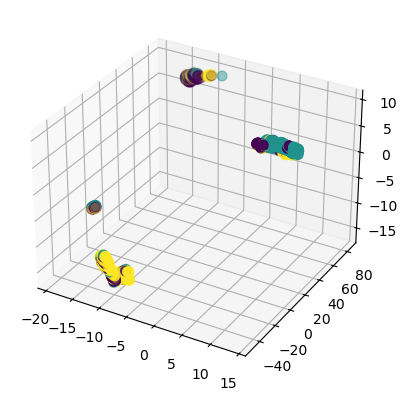

In [50]:
import umap
import umap.plot
# Kalan veriye reduction uyguluyorum
def train_model_umap(data, n_components, write_on=False):
    folder_name = os.path.join('data', 'models')
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    file_name = os.path.join(folder_name, f'model_umap_{n_components}.pkl')
    if os.path.exists(file_name) and (not write_on):
        with open(file_name, "rb") as model_file:
            model_umap = pickle.load(model_file)
    else:
        model_umap = umap.UMAP(n_neighbors=20,
        min_dist=0.28,
        n_components=n_components,
        metric="euclidean")
        model_umap.fit(data)
        with open(file_name, "wb") as model_file:
            pickle.dump(model_umap, model_file)
    return model_umap

# Gösterebilmek için 3'e indiriyorum
model_umap_3 = train_model_umap(train_features, 3)
train_features_umap_3 = model_umap_3.transform(train_features) 
# 3 boyutlu olarak gösteremiyor
# umap.plot.points(model_umap_3, labels=train_labels, theme='fire')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_features_umap_3[:,0], train_features_umap_3[:,1], train_features_umap_3[:,2], c=train_labels, s=50)

In [51]:
# 10 veriye indirmek istedim. Makine öğrenmesine veri çok az olmasın diye
model_umap_10 = train_model_umap(train_features, 10)
train_features = model_umap_10.transform(train_features) 
test_features = model_umap_10.transform(test_features) 

In [52]:
train_features.shape
train_labels.shape

(1505, 10)

(1505,)

## Makine Öğrenmesi

In [53]:
from distfit import distfit

# Hepsine en yakın normal dağılım dedi
def dist_check(df, variable):
    dfit = distfit()
    results = dfit.fit_transform(df.loc[a].to_numpy())
    results['summary']
train = pd.DataFrame(train_features)
for a in train.columns:
    dist_check(train, a)

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.000366181] [loc=2.511 scale=14.203]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.000582689] [loc=-14.574 scale=17.085]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.00220697] [loc=-14.574 scale=0.000]
[distfit] >INFO> [dweibull  ] [0.01 sec] [RSS: 0.000449449] [loc=0.648 scale=12.330]
[distfit] >INFO> [t         ] [0.10 sec] [RSS: 0.000299548] [loc=1.567 scale=12.404]
[distfit] >INFO> [genextreme] [0.08 sec] [RSS: 0.000257136] [loc=-4.059 scale=11.339]
[distfit] >INFO> [gamma     ] [0.04 sec] [RSS: 0.000855222] [loc=-14.574 scale=26.932]
[distfit] >INFO> [lognorm   ] [0.08 sec] [RSS: 0.00103542] [loc=-14.730 scale=7.367]
[distfit] >INFO> [beta      ] [0.06 sec] [RSS: 0.000945273] [loc=-14.574 scale=207.045]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.000818316] [loc=-14.574 scale=49.437]
[distfit] >INFO> [loggamma  ] [0.04 sec] [RSS: 0.000381194] [loc=-3900.633 scale=539.478]
[d

In [43]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


# KFold ve GridSearchCV için parametreler
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)  
# average ve multi class parametreleri vermeme rağmen roc_auc_score değer dönmüyordu.
scoring = make_scorer(f1_score, average='weighted')
models = {
    # lasso regression
    'Logistic Regression': LogisticRegression(multi_class='ovr', solver='liblinear'),
    'RidgeClassifier': RidgeClassifier(),
    'KNeighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(objective='multi:softprob'),
    'CatBoost': CatBoostClassifier(loss_function='MultiClassOneVsAll', verbose=False)
}

# GridSearchCV için parametre aralıkları
param_grids = {
    'Logistic Regression': {'C': [0.1, 1.0, 10.0], 'penalty': ['l1', 'l2']},
    'RidgeClassifier': {'alpha': [0.1, 1.0, 10.0], 'solver': ['auto', 'svd', 'cholesky']},
    'KNeighbors': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
    'XGBoost': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7, 10], 'learning_rate': [0.01, 0.1, 0.2]},
    'CatBoost': {'iterations': [50, 100, 200], 'depth': [3, 5, 7, 10], 'learning_rate': [0.01, 0.1, 0.2]}
}

folder_name = os.path.join('data', 'models')
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
            
# GridSearchCV'yi ve çapraz doğrulamayı kullanarak modelleri eğitme
results = {}
for name, model in models.items():

    print(f"Training {name}...")
    grid_search = GridSearchCV(model, param_grids[name], scoring=scoring, cv=kfold)
    grid_search.fit(train_features, train_labels)
    results[name] = grid_search

Training Logistic Regression...


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=LogisticRegression(multi_class='ovr',
                                          solver='liblinear'),
             param_grid={'C': [0.1, 1.0, 10.0], 'penalty': ['l1', 'l2']},
             scoring=make_scorer(f1_score, average=weighted))

Training RidgeClassifier...


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RidgeClassifier(),
             param_grid={'alpha': [0.1, 1.0, 10.0],
                         'solver': ['auto', 'svd', 'cholesky']},
             scoring=make_scorer(f1_score, average=weighted))

Training KNeighbors...


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(f1_score, average=weighted))

Training XGBoost...


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softprob', ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(f1_score, average=weighted))

Training CatBoost...


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x00000179915F2890>,
             param_grid={'depth': [3, 5, 7, 10], 'iterations': [50, 100, 200],
                         'learning_rate': [0.01, 0.1, 0.2]},
             scoring=make_scorer(f1_score, average=weighted))

In [44]:
# Sonuçları yazdırma
for name, result in results.items():
    print(f"Best {name} Parameters: {result.best_params_}")
    print(f"Best {name} Score: {result.best_score_}")
    test_predictions = result.best_estimator_.predict(test_features)
    accuracy = accuracy_score(test_labels, test_predictions)
    report = classification_report(test_labels, test_predictions)
    print(f"Accuracy: {accuracy}")
    print("Classification Report:\n", report)

Best Logistic Regression Parameters: {'C': 10.0, 'penalty': 'l2'}
Best Logistic Regression Score: 0.751766115219937
Accuracy: 0.4742974640164496
Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.30      0.22       311
           1       0.82      0.12      0.21       468
           2       0.64      0.80      0.71       680

    accuracy                           0.47      1459
   macro avg       0.55      0.41      0.38      1459
weighted avg       0.60      0.47      0.45      1459

Best RidgeClassifier Parameters: {'alpha': 0.1, 'solver': 'auto'}
Best RidgeClassifier Score: 0.7425086769180399
Accuracy: 0.46401644962302946
Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.30      0.22       311
           1       0.77      0.09      0.16       468
           2       0.64      0.80      0.71       680

    accuracy                           0.46      1459
   macro av

Burda en iyi gözüken model XGBoost,CatBoost ve KNeighbors, aslında test sonuçlarına bakınca modelin öğrenmediği söylenebilir. Ama bu test verisinin aslında yüzde 46-70'den fazla null içeren verilerden başladığını unutmamak lazım. Aslında anlamsız bir veri olduğunu söyleyebiliriz. Zaten siz test verisi yok demiştiniz ben merağımdan yaptım.<br>
Gerçek bir test versi olmadığından McNemar's test yapmıyorum<br>
Bir çok hiperparametre ile oynanarak (özellikle veri hazırlama aşaması) daha fazla deneme yapılabilir<br>

In [54]:
# Saving the XGBoost model
# Model'in save'ini alıyorum ki her çalıştırdığımda test verisine yaptığım yorumları değiştirmeyeyim
# Çoklukla ya XGBoost CatBoost ve KNeighbors daha yüksek skor verdi
# Alttaki sektör sektör bakma fonksiyonuyla xgboost'a karar verdim (Yani aslında çok fark göremedim, alan bilgim de az)
folder_name = os.path.join('data', 'models')
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
file_name = os.path.join(folder_name, 'xgboost.pkl')
if os.path.exists(file_name):
    with open(file_name, "rb") as model_file:
        xgboost = pickle.load(model_file)
else:
    with open(file_name, "wb") as model_file:
        pickle.dump(results["XGBoost"].best_estimator_, model_file)
        xgboost = results["XGBoost"].best_estimator_

## Testing
Yukarıda veriye uyguladığım aynı işlemleri yeniden eğitim yapmadan sektör sektör uyguluyorum, outlier ve çok null içeren column'ları silme işlemleri hariç, o yüzden tek tek açıklamayacağım. Çok null içeren column'ları(hisseleri) silmiyorum çünkü test verisini reddetmiş oluyorum böylelikle. Ama yüzde 95'den fazla içerenleri siliyorum, artık o da neredeyse tamamıyla boş bir veri.
## CatBoost modelini denerken alttaki iki fonksiyondaki not aldığım kısmı değiştiriniz.

### Buranın doğru çalışması için tüm notebook'un baştan bu kısıma sıralı bir şekilde çalıştırılması lazım, bazı veriler yukarıdaki cell'lerden geliyor. Hataya sebep olabilir sıraya uymazsak

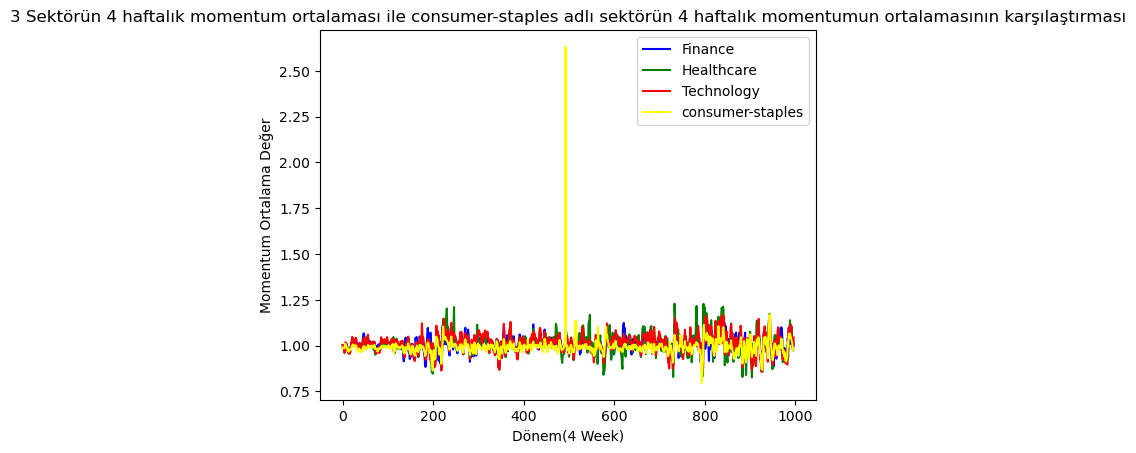

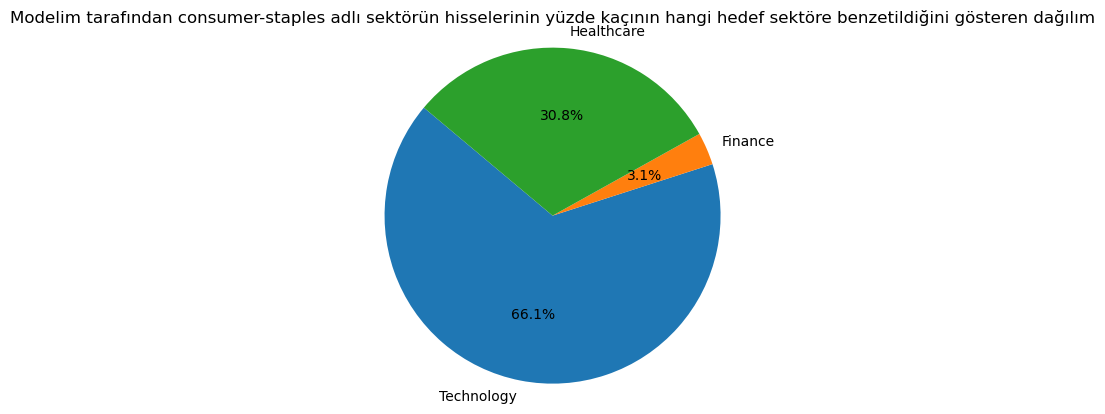

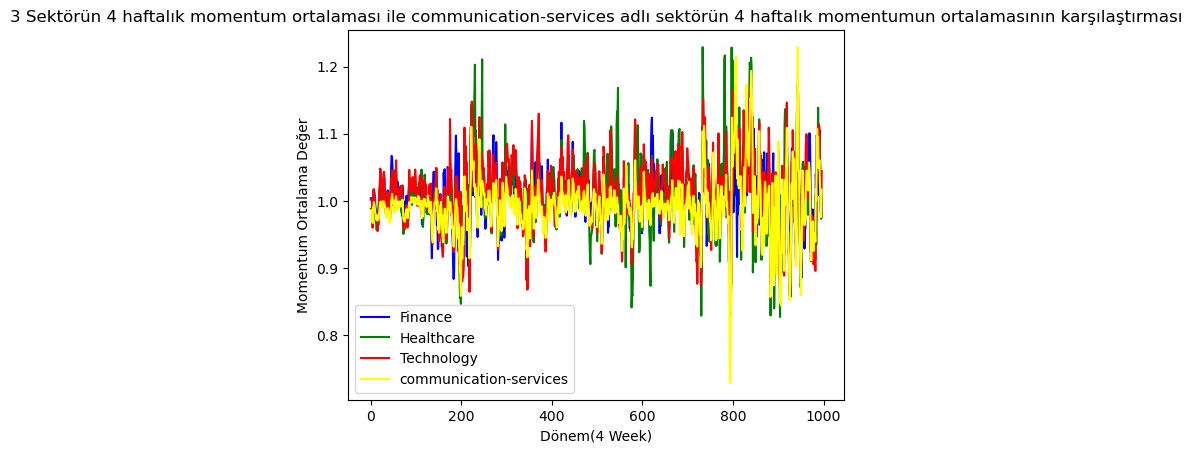

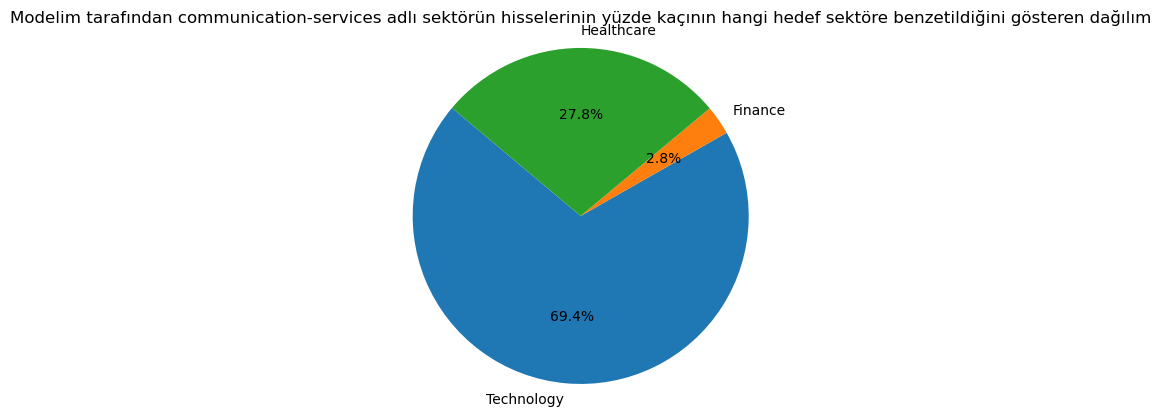

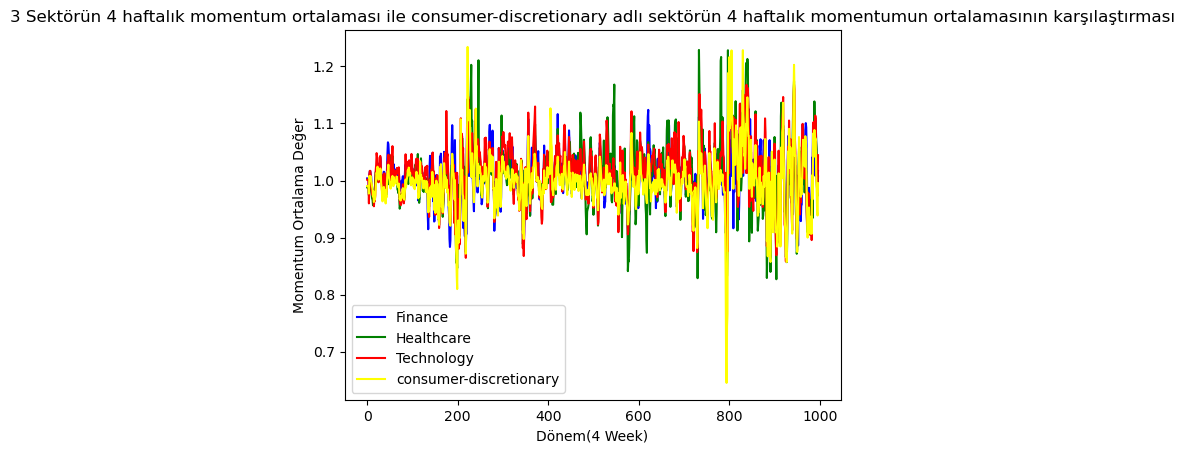

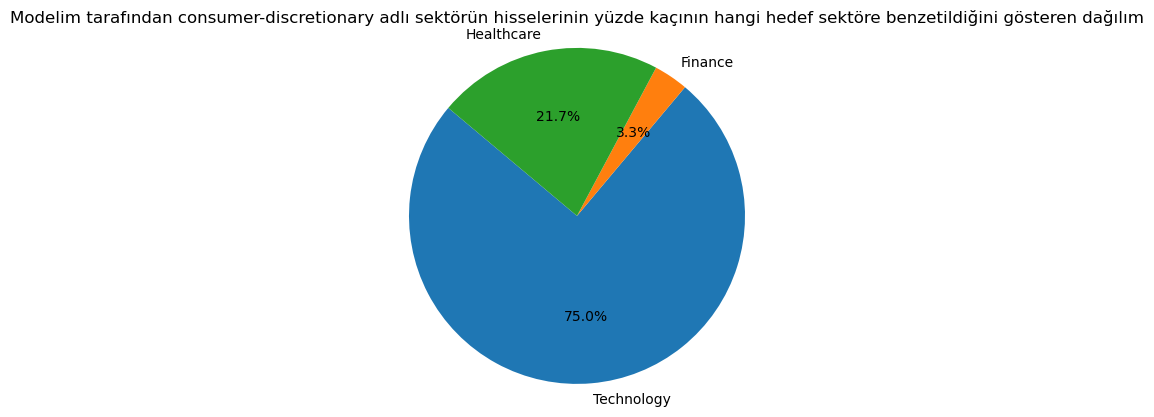

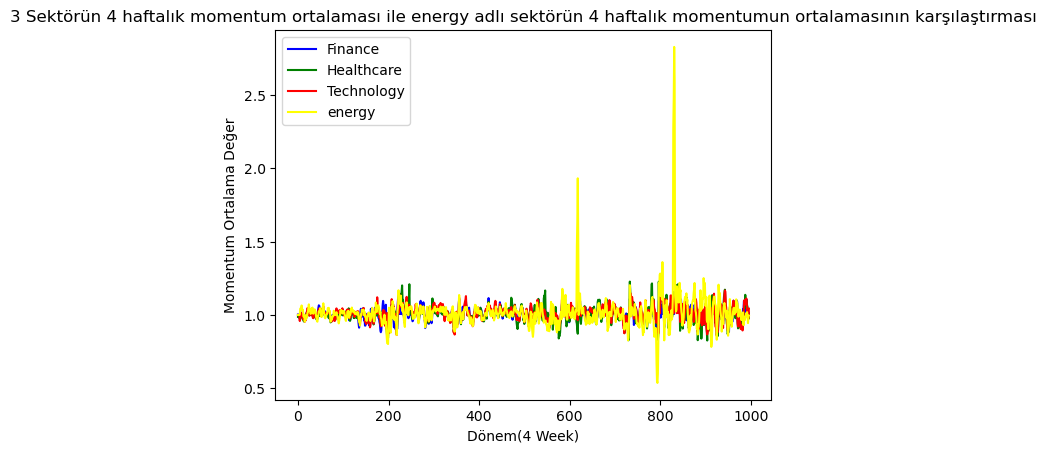

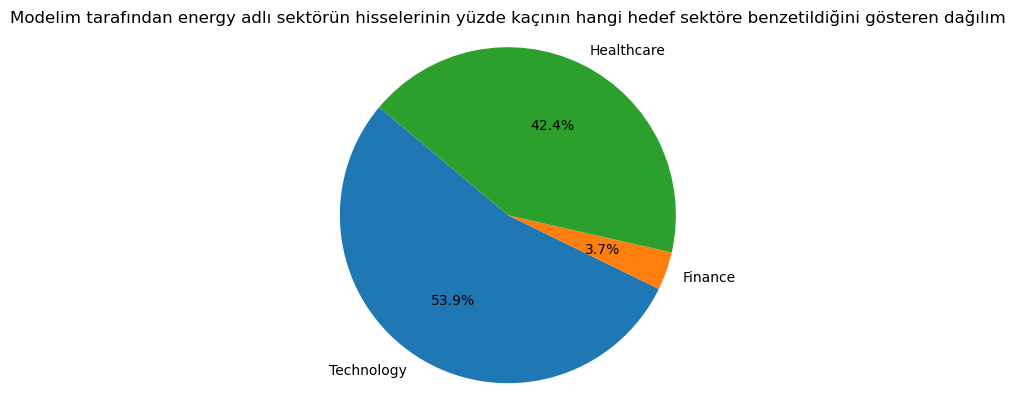

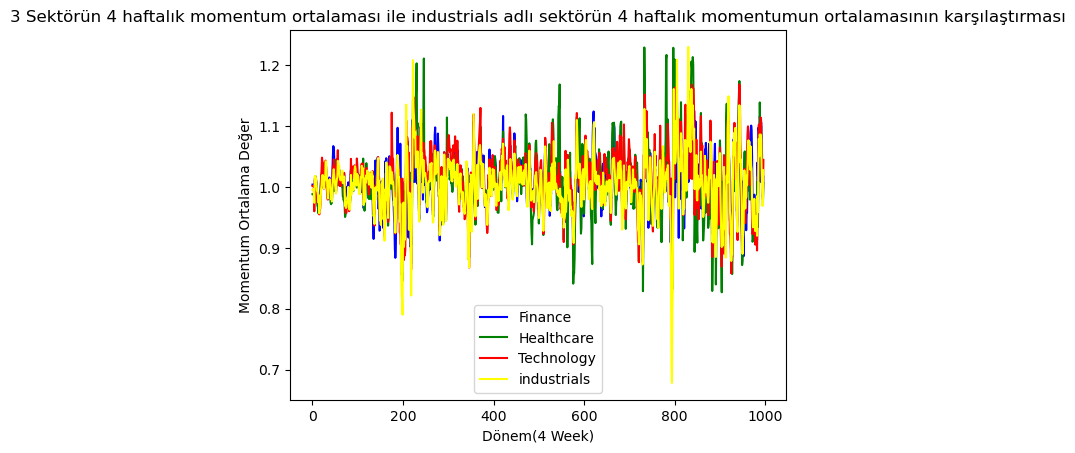

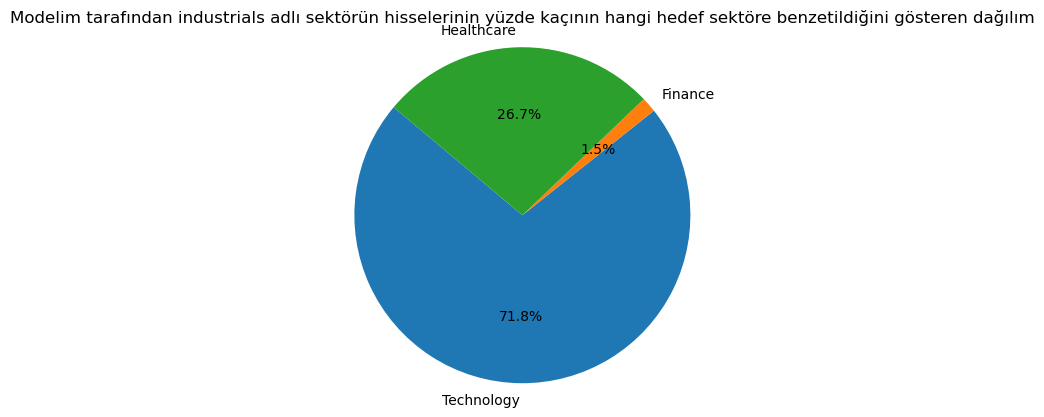

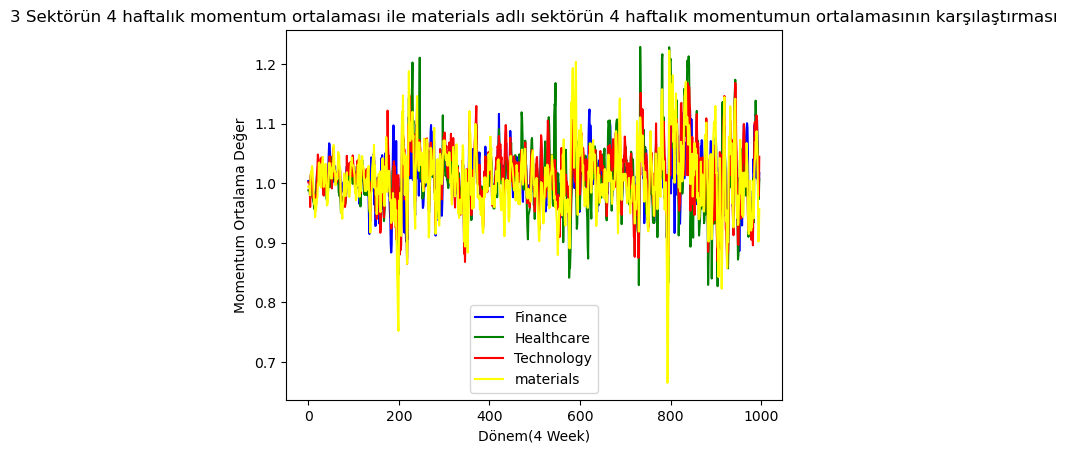

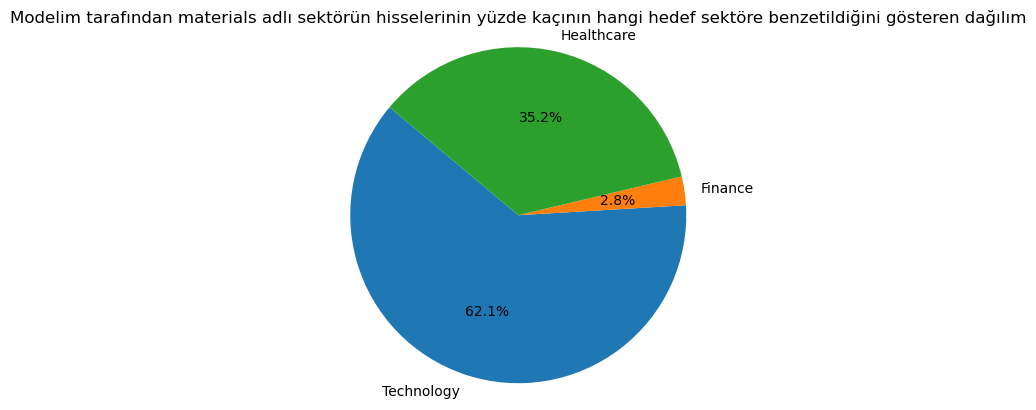

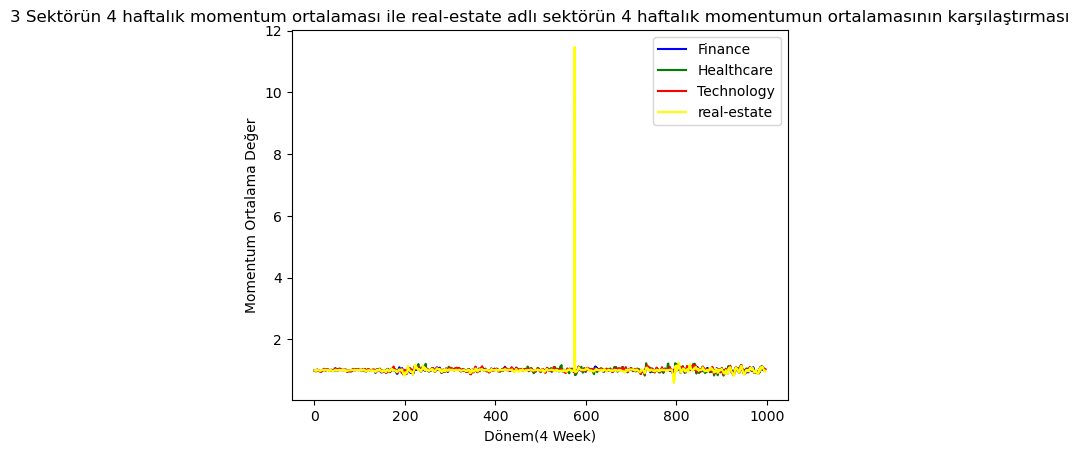

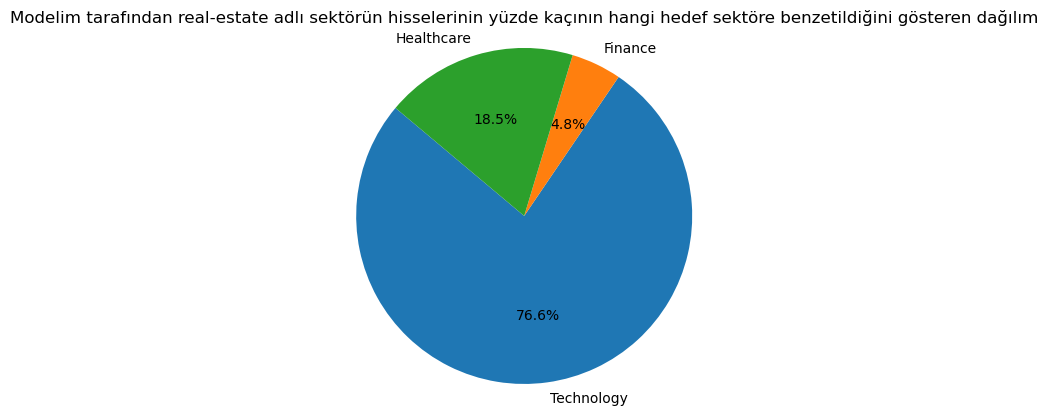

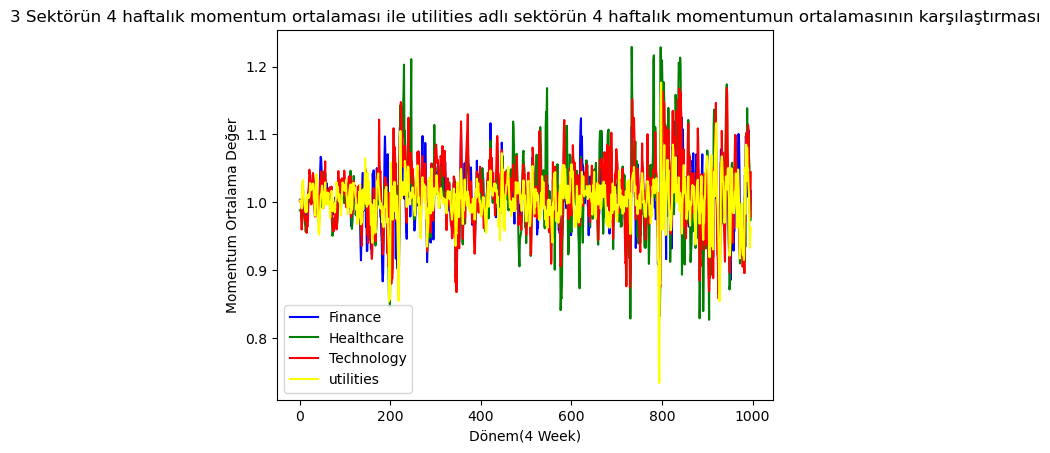

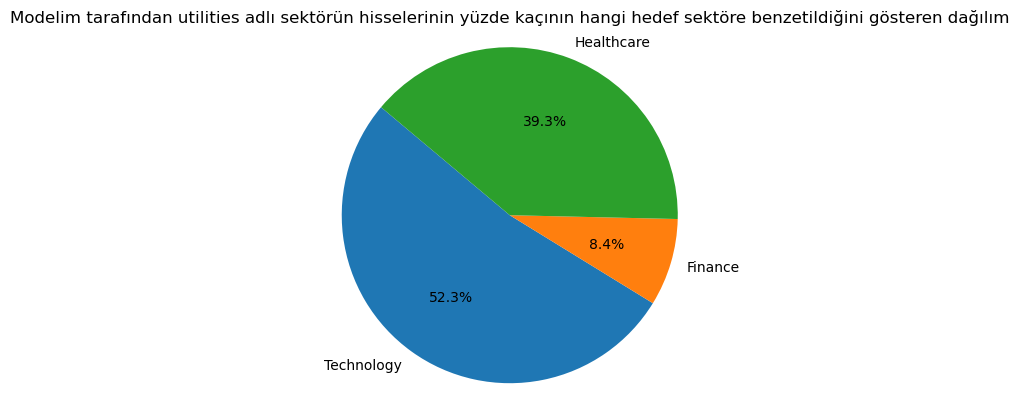

In [55]:
sectors_list = ["consumer-staples", "communication-services", "consumer-discretionary", "energy", "industrials", "materials", "real-estate", "utilities"]
def sector_fit(sector_name, columns_to_drop_after_tsfresh, non_unique_columns, 
               simple_imputer, robust_scaler, selector_drop_duplicate, selector, model_rfe, model_anova, model_umap_10, model):
    # Veriyi çekmek
    sector = pd.read_csv(f'./data/sectors-data/{sector_name}_data.csv')
    symbols = sector['Symbol'].dropna().tolist()
    all_data_close = get_shares_data(symbols, sector_name, write_on = False)
    
    # Momentumun hesaplanması
    data_momentum = get_rolling_momentum(sector_name, all_data_close, 4).replace([np.inf, -np.inf], np.nan)

    # Null verilerden temizlik
    dropped_columns = drop_column_according_to_null_percentage(95, data_momentum)
    imputer = SimpleImputer(strategy='median')
    imputed_data = clear_the_null(imputer, data_momentum)

    # Çizgi grafik
    sector_mean = imputed_data.copy().mean(axis=1)
    finance_mean = clean_finance_data_copy.mean(axis=1)
    healthcare_mean = clean_healthcare_data_copy.mean(axis=1)
    technology_mean = clean_technology_data_copy.mean(axis=1)
    plt.plot(finance_mean.values, label='Finance', color='blue')
    plt.plot(healthcare_mean.values, label='Healthcare', color='green')
    plt.plot(technology_mean.values, label='Technology', color='red')
    plt.plot(sector_mean.values, label=sector_name, color="yellow")
    plt.ylabel('Momentum Ortalama Değer')
    plt.xlabel('Dönem(4 Week)')
    plt.title(f'3 Sektörün 4 haftalık momentum ortalaması ile {sector_name} adlı sektörün 4 haftalık momentumun ortalamasının karşılaştırması')
    plt.legend()
    plt.show()    
    
    # tsfresh
    test_data = readying_for_tsfresh(f"{sector_name}-test", imputed_data)
    test_features = extract_features(f"{sector_name}-test", test_data, "id", "Date")
    data_type_setup(test_features)
    test_features.drop(columns=columns_to_drop_after_tsfresh, inplace=True)
    test_features.drop(columns=non_unique_columns, inplace=True)
    test_features = simple_imputer.transform(test_features)

    # Scaling
    test_features = robust_scaler.transform(test_features)

    # Duplicate feature cleaning(yani aslında test verisinde duplicate olmayabilir ama train'de öyleydi)
    test_features = selector_drop_duplicate.transform(test_features)
    test_features = save_or_get_before_feature_selection_data(f"{sector_name}-test", test_features, write_on=False)

    # Feature selection
    test_features = selector.transform(test_features)
    test_features = model_rfe.transform(test_features)
    test_features = model_anova.transform(test_features)

    # Feature extraction
    test_features = model_umap_10.transform(test_features) 

    # Testing
    # !!!!!!!!!!!!! CatBoost verilirse burası alttaki koda değiştirilmeli
    #test_predictions = model.predict(test_features).flatten()
    
    test_predictions = model.predict(test_features)
    labels = ['Technology', 'Finance', 'Healthcare']
    category_counts = np.bincount(test_predictions.astype(int))
    sizes = [category_counts[0], category_counts[1], category_counts[2]]
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  
    plt.title(f'Modelim tarafından {sector_name} adlı sektörün hisselerinin yüzde kaçının hangi hedef sektöre benzetildiğini gösteren dağılım')  
    plt.show()  
    

for sector in sectors_list:
    sector_fit(sector, columns_to_drop_after_tsfresh, non_unique_columns, 
               simple_imputer, robust_scaler, selector_drop_duplicate, selector, model_rfe, model_anova, model_umap_10, xgboost)

[*********************100%%**********************]  3 of 3 completed
[distfit] >WARNING> Dependency not available for matrix_profile, this feature will be disabled!
Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.69s/it]


[0 0 2]


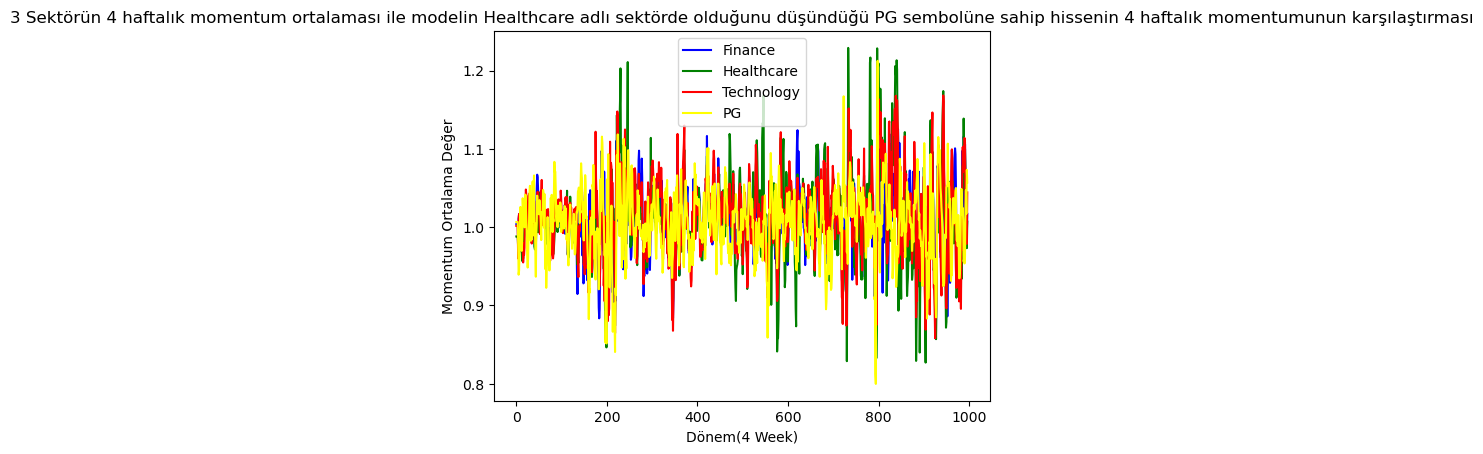

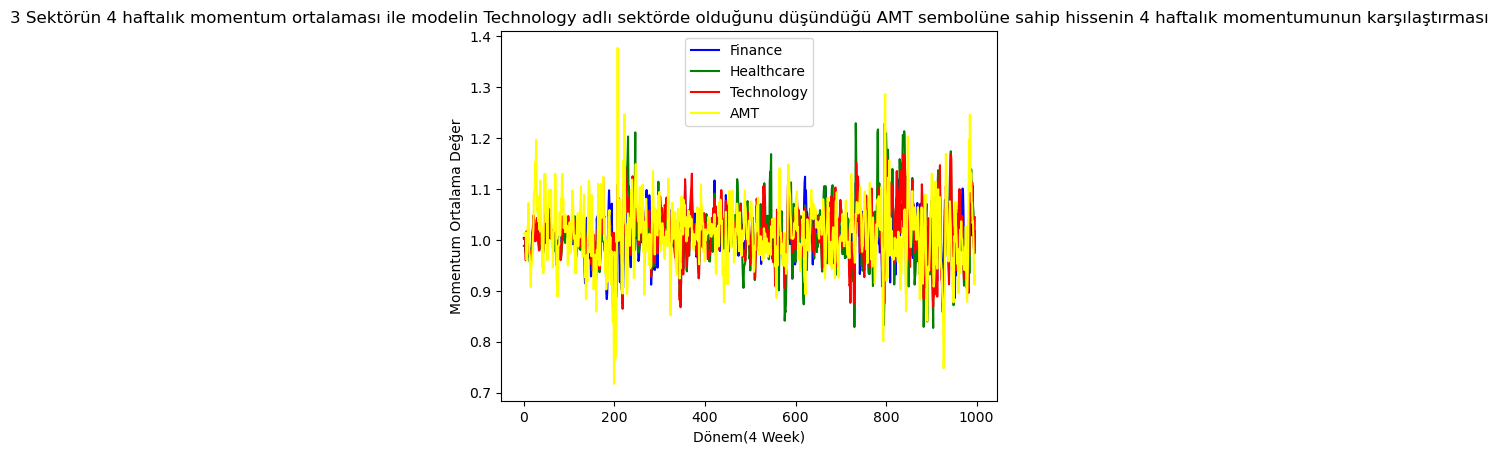

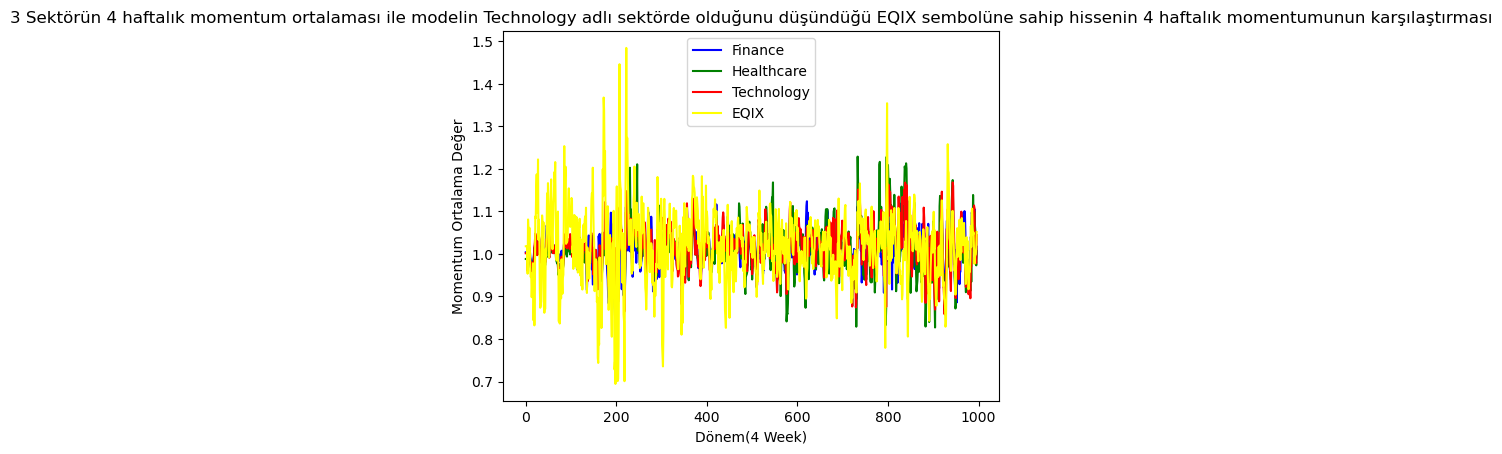

In [56]:
def share_sector_comparison(share_name, columns_to_drop_after_tsfresh, non_unique_columns, 
               simple_imputer, robust_scaler, selector_drop_duplicate, selector, model_rfe, model_anova, model_umap_10, model):
    all_data_close = get_shares_data(share_name, "Hisse", write_on=True)

    # Grafik için hazırlık
    finance_mean = clean_finance_data_copy.mean(axis=1)
    healthcare_mean = clean_healthcare_data_copy.mean(axis=1)
    technology_mean = clean_technology_data_copy.mean(axis=1)

    # Momentumun hesaplanması
    data_momentum = get_rolling_momentum("Hisse", all_data_close, 4, write_on=True).replace([np.inf, -np.inf], np.nan)

    # Null verilerden temizlik
    check = np.max(data_momentum.isnull().mean() * 100)
    if check == 100:
        print("Hisselerden en az birinin verisi eksik")
    else:
        imputer = SimpleImputer(strategy='median')

        imputed_data = clear_the_null(imputer, data_momentum)

        # tsfresh
        test_data = readying_for_tsfresh("Hisse", imputed_data, write_on=True)
        test_features = extract_features("Hisse", test_data, "id", "Date", write_on=True)
        data_type_setup(test_features)
        test_features.drop(columns=columns_to_drop_after_tsfresh, inplace=True)
        test_features.drop(columns=non_unique_columns, inplace=True)
        test_features = simple_imputer.transform(test_features)
    
        # Scaling
        test_features = robust_scaler.transform(test_features)
    
        # Duplicate feature cleaning(yani aslında test verisinde duplicate olmayabilir ama train'de öyleydi)
        test_features = selector_drop_duplicate.transform(test_features)
        test_features = save_or_get_before_feature_selection_data("Hisse", test_features, write_on=True)
    
        # Feature selection
        test_features = selector.transform(test_features)
        test_features = model_rfe.transform(test_features)
        test_features = model_anova.transform(test_features)
    
        # Feature extraction
        test_features = model_umap_10.transform(test_features) 
        
        # !!!!!!!!!!!!! CatBoost verilirse burası alttaki koda değiştirilmeli
        # test_predictions = model.predict(test_features).flatten()
    
        test_predictions = model.predict(test_features)    
        print(test_predictions)
        sectors = ["Technology", "Finance", "Healthcare"]
        
        for share in share_name:
            plt.plot(finance_mean.values, label='Finance', color='blue')
            plt.plot(healthcare_mean.values, label='Healthcare', color='green')
            plt.plot(technology_mean.values, label='Technology', color='red')
            plt.plot(imputed_data.loc[:, share].values, label=share, color="yellow")
            plt.ylabel('Momentum Ortalama Değer')
            plt.xlabel('Dönem(4 Week)')
            plt.title(f'3 Sektörün 4 haftalık momentum ortalaması ile modelin {sectors[test_predictions[imputed_data.columns.get_loc(share)]]} adlı sektörde olduğunu düşündüğü {share} sembolüne sahip hissenin 4 haftalık momentumunun karşılaştırması')
            plt.legend()
            plt.show()

share_sector_comparison(['PG', 'AMT', 'EQIX'], columns_to_drop_after_tsfresh, non_unique_columns, 
               simple_imputer, robust_scaler, selector_drop_duplicate, selector, model_rfe, model_anova, model_umap_10, xgboost)

Bu grafikteki değerler ilk outlier detection'dan sonrasındaki veri setinin ortalaması hesaplanarak çizilmiştir. O outlier gibi duran değerlerini tespit edememiş olmam modelin zayıf olmasının en büyük sebebi olabilir. Büyük ihtimal bir kaç hafta devam eden bir durum olduğundan outlier olarak görmemiştir diye düşünüyorum. Sektör dışı bazı hisselerin grafiğini koydum ama çok diyebileceğim bir şey yok. Bilgim olan bi alan değil.
Bir google için teknoloji hissesi olması mantıklı diyebilirim

## Notlar
Aslında 3 Aylık momentum, KFold ve MICE kullandığım ilk denememde modellerin skorları %85 civarı geliyordu ama aslında sektör sektör pie chart bakınca hepsine %70-80 teknoloji diyordu. Bu daha iyi duruyor. İlk haline StratifiedKFold uygulasam daha iyi sonuçlar alabilirdim belki ama zaten doğrudan MICE kullanmam yol olarak yanlıştı bence<br>
Veriyi yıllara bölüp her yıl için bir model eğitip, bu modellerin output'larını de en son ağaç modelleri gibi bir modele bağlasak çok daha iyi olur diye düşünüyorum. Hatta yıl yıl değil büyük olayların olduğu yıllar olarak bölebiliriz<br>
Veri miktarı az diye bol bol kaydettim bir daha çalıştırmamak için bazı kısımları<br>
Ana veride outlier detection yapıyorum (sektörlerin krizlerini çıkarıyor olmalı), ama test verisinde bunu yapmıyorum. Bu da test sektörlerinin ayrışmasına sebep oluyor. Aslında outlier burada gerçek bir veri olduğundan train veri setinden de çıkarmamak lazımdı bence ama<br>
Çıkarmazsak daha çok kriz dönemlerini öğrenen bir modelimiz olur<br>
Çıkarırsak hisselerin normal dağılımını öğrenen bir model olur<br>
Ben burada hisselerin normal dağılımından sonuç çıkarmaya uğraştım, o yüzden modellerin skorları düşük gelmiş olabilir zaten, krizler sayesinde train verisinden yüksek skor alması zor olmazdı büyük ihtimalle<br>
Şimdi yukarıda sektör sektör baktığım işlemi birde sektörleri aykırı değerlerden çıkarıp yapmak istiyorum normal dağılımlarından nasıl tahmin ediyor görmek için

### Cevabını bulamadığım bir şey oldu. Hisseleri tek tek test eederken aynı sonuçları alıyorum aynı hisseleri verirsem ama içlerinden birini bile çıkarsam tahminler değişebiliyor. Bulamadım sebebini, bir yerde hatam var galiba...

## Aslında medium ile doldururken hisselerin medium değil de günün medium değeriyle doldurmam daha mantıklı olurdu, ama artık final projeme dönmem lazım...

consumer-staples-test-2 Aykırı Veri Sayısı: 34
997
(997, 224)


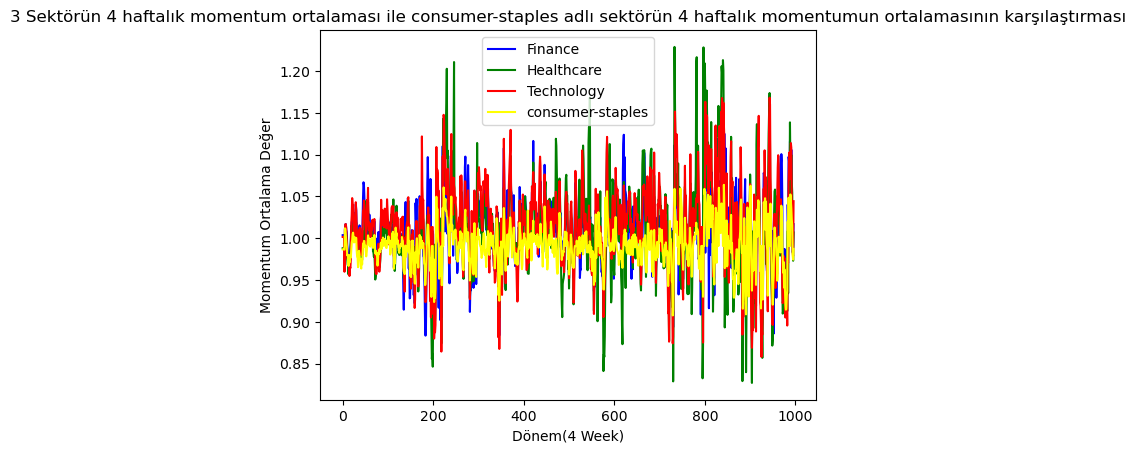

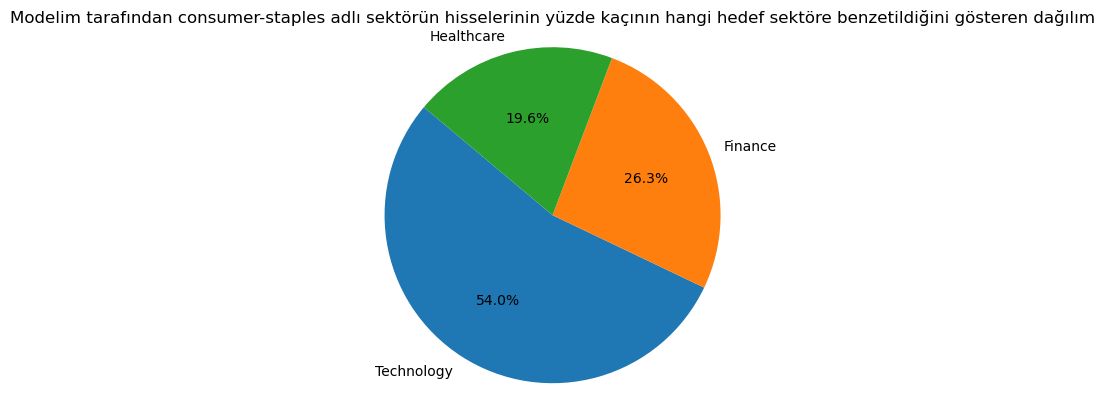

communication-services-test-2 Aykırı Veri Sayısı: 13
997
(997, 248)


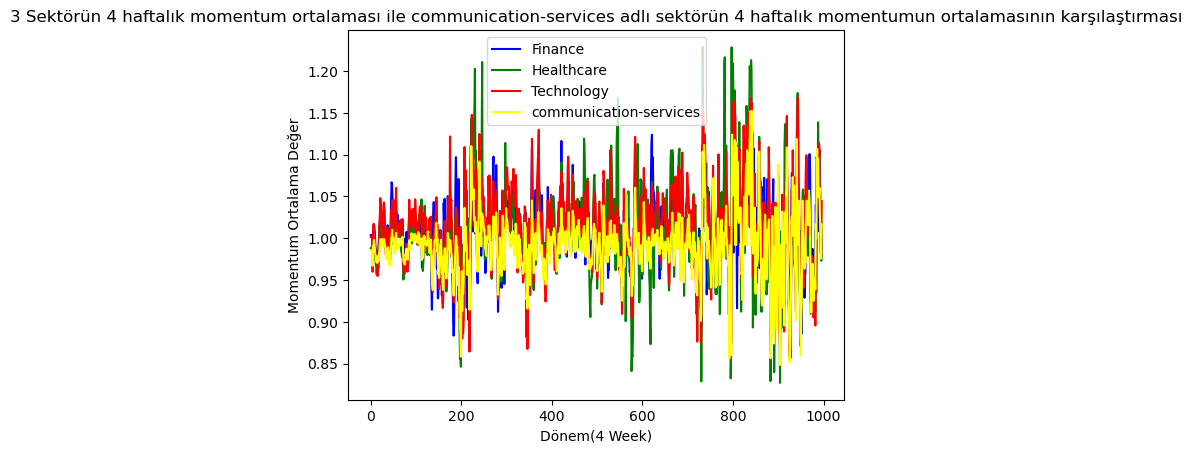

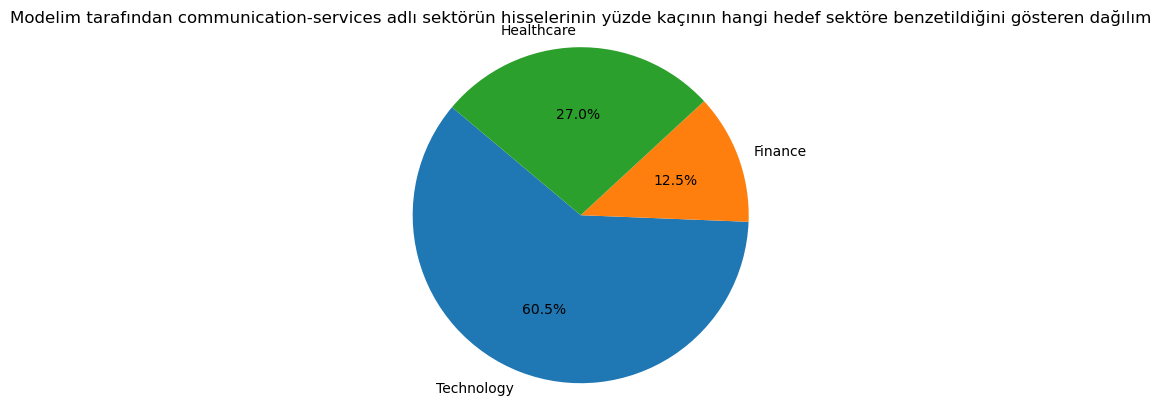

consumer-discretionary-test-2 Aykırı Veri Sayısı: 26
997
(997, 544)


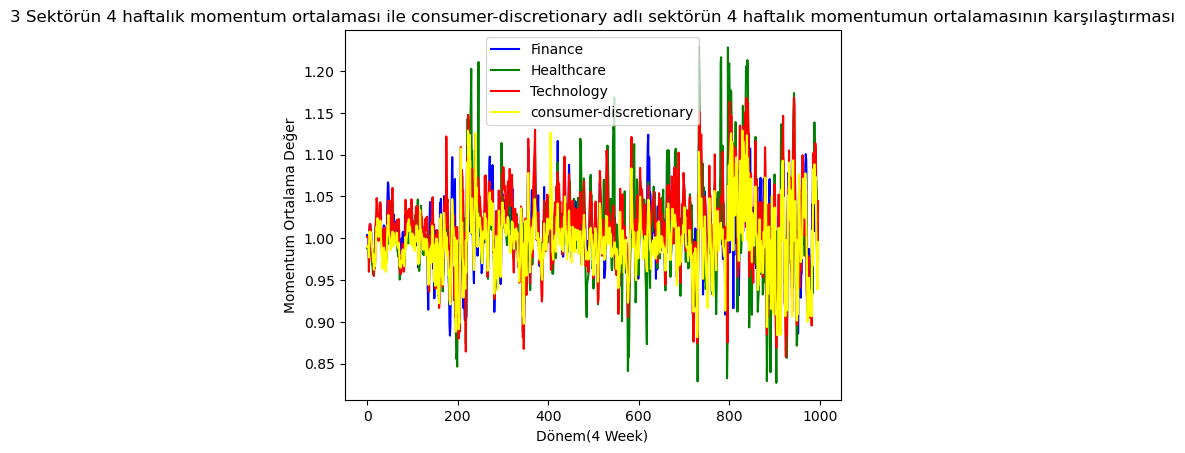

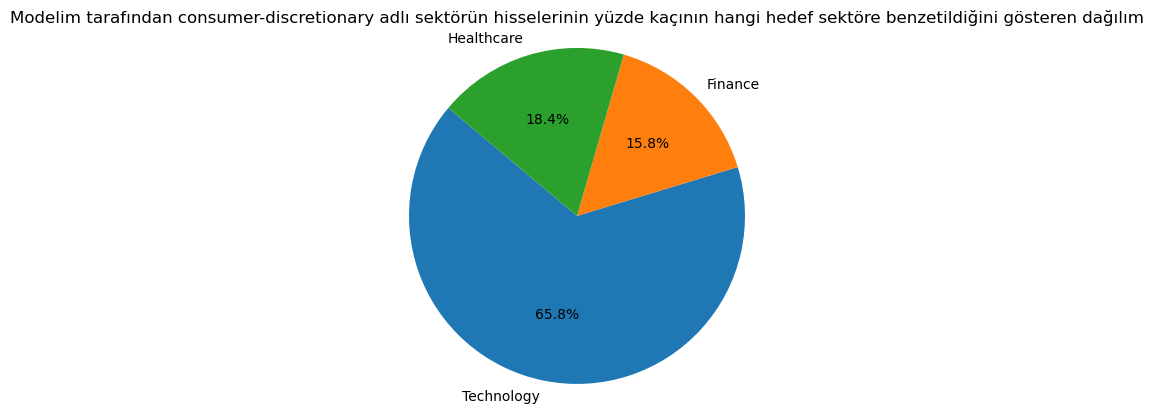

energy-test-2 Aykırı Veri Sayısı: 31
997
(997, 245)


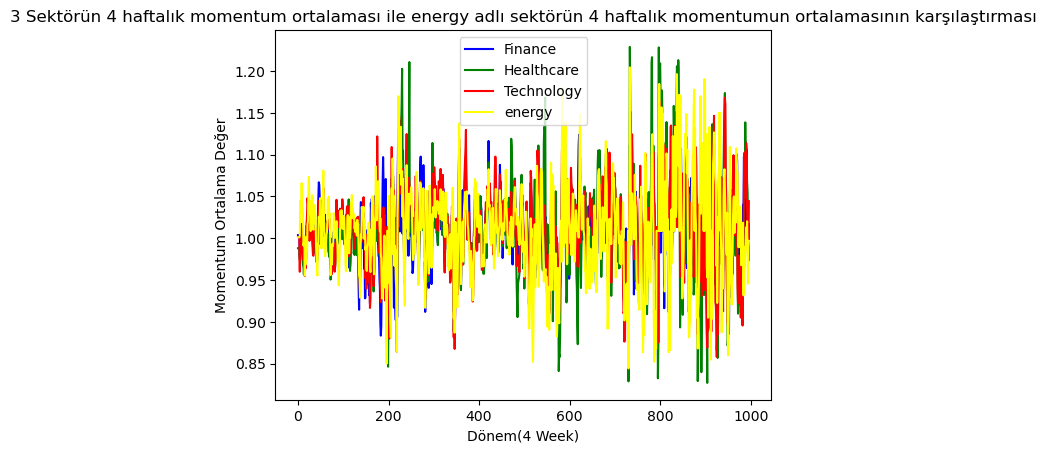

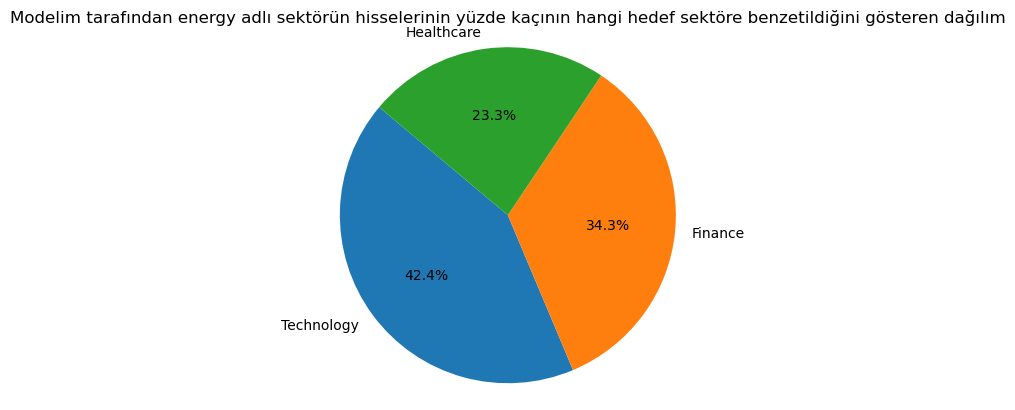

industrials-test-2 Aykırı Veri Sayısı: 22
997
(997, 617)


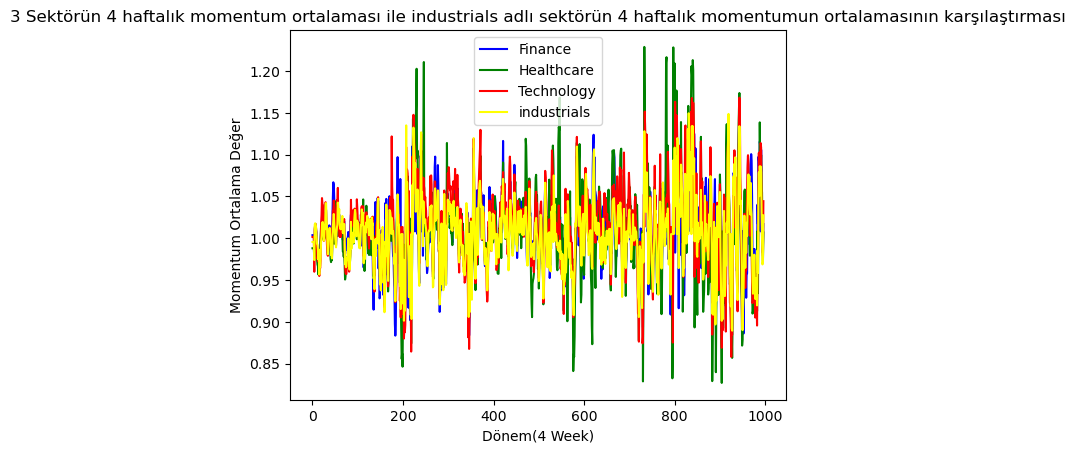

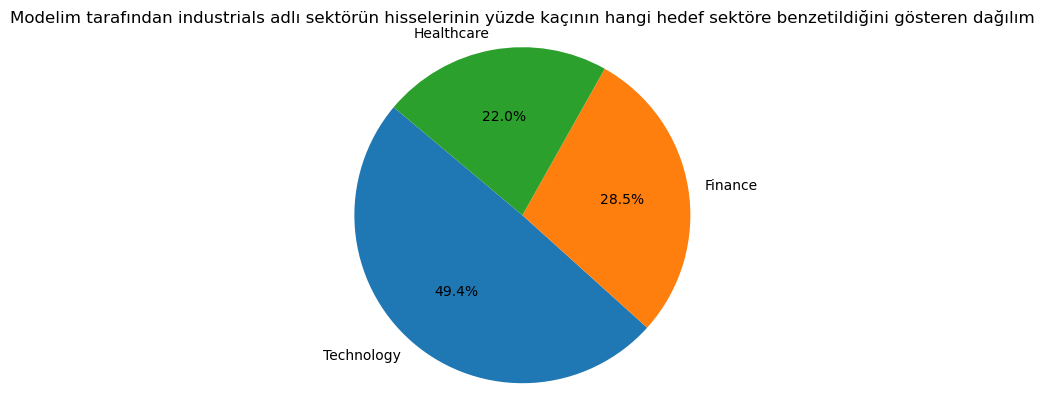

materials-test-2 Aykırı Veri Sayısı: 23
997
(997, 253)


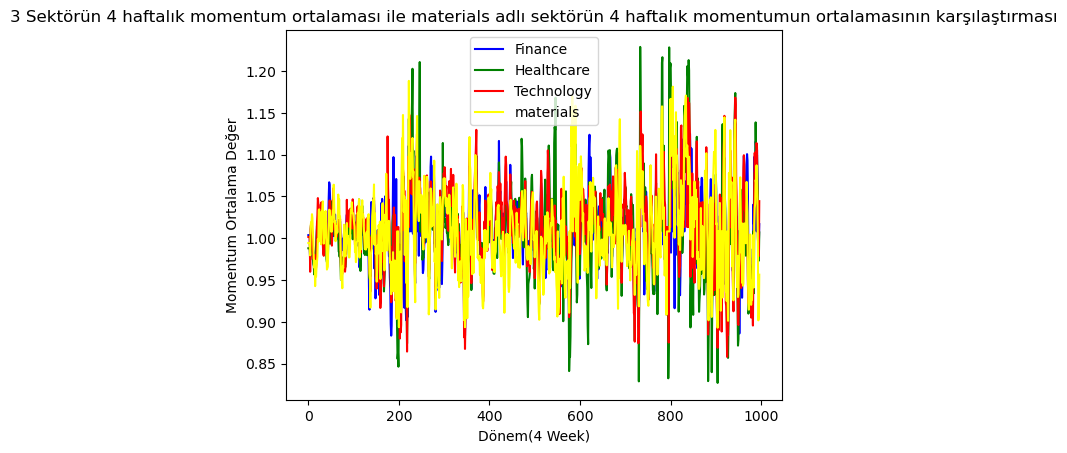

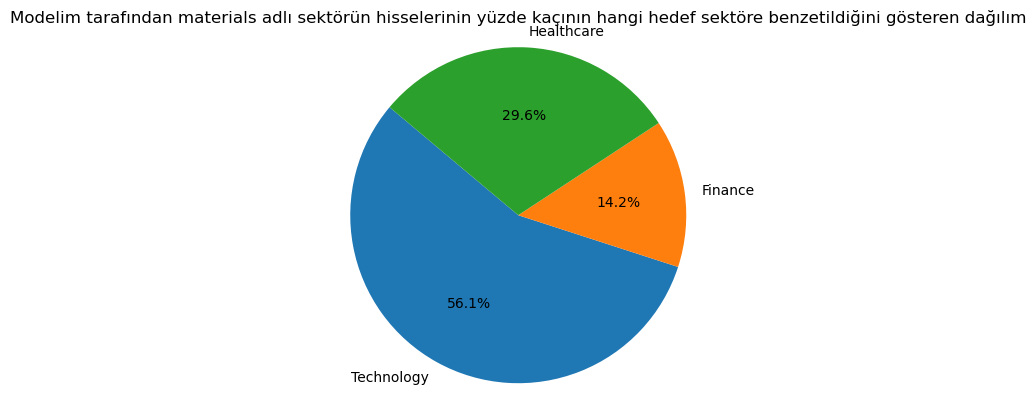

real-estate-test-2 Aykırı Veri Sayısı: 26
997
(997, 248)


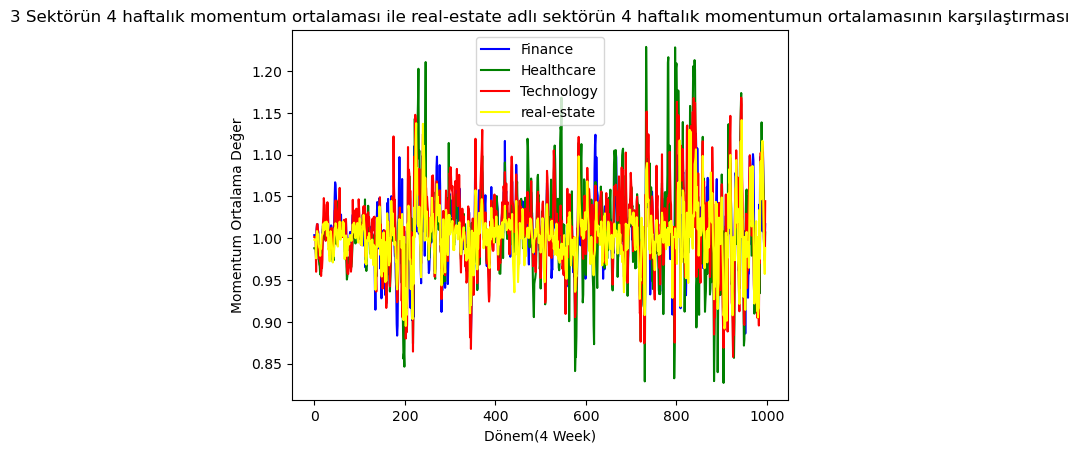

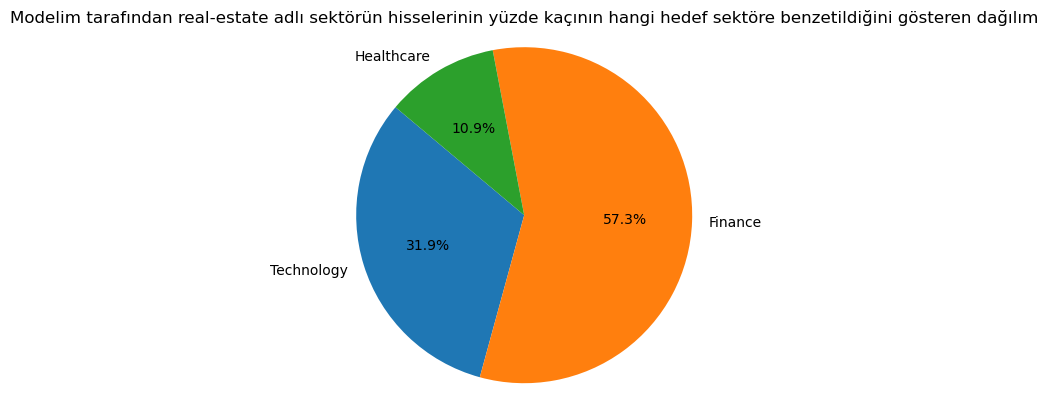

utilities-test-2 Aykırı Veri Sayısı: 29
997
(997, 107)


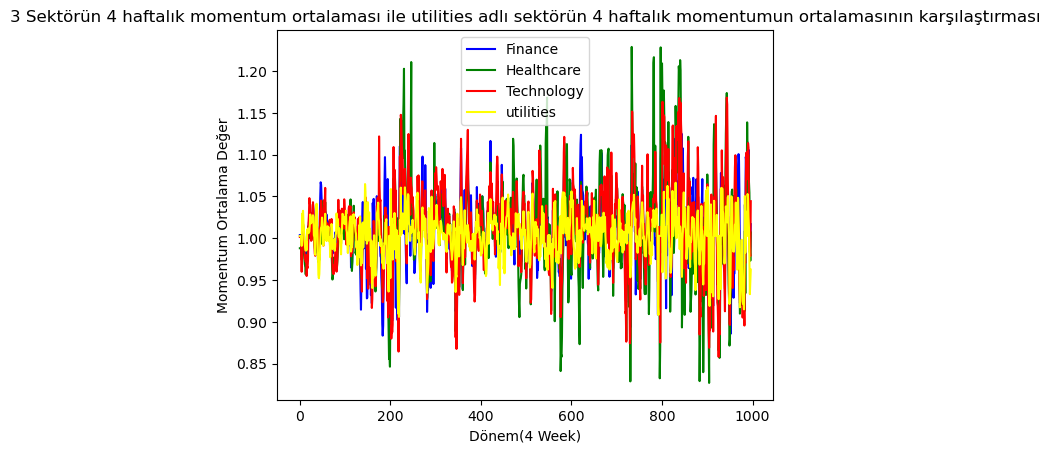

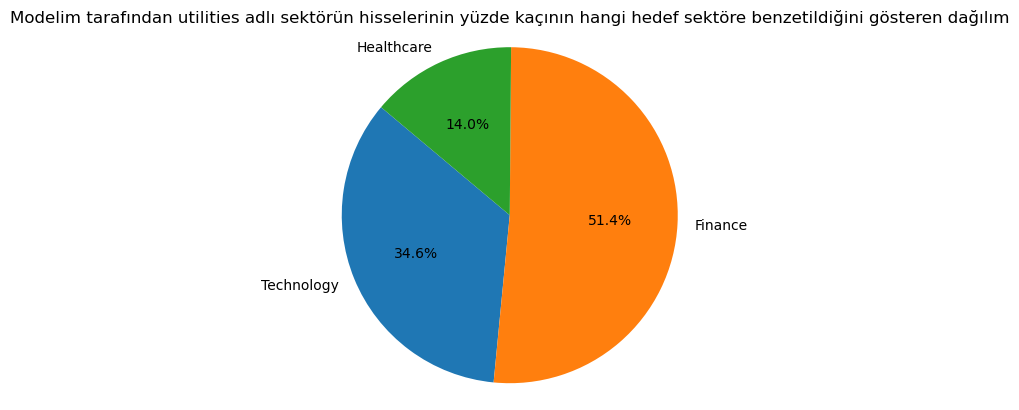

In [57]:
sectors_list = ["consumer-staples", "communication-services", "consumer-discretionary", "energy", "industrials", "materials", "real-estate", "utilities"]
def sector_fit(sector_name, columns_to_drop_after_tsfresh, non_unique_columns, 
               simple_imputer, robust_scaler, selector_drop_duplicate, selector, model_rfe, model_anova, model_umap_10, model):
    # Veriyi çekmek
    sector = pd.read_csv(f'./data/sectors-data/{sector_name}_data.csv')
    symbols = sector['Symbol'].dropna().tolist()
    all_data_close = get_shares_data(symbols, sector_name, write_on = False)
    
    # Momentumun hesaplanması
    data_momentum = get_rolling_momentum(sector_name, all_data_close, 4).replace([np.inf, -np.inf], np.nan)

    # Null verilerden temizlik
    dropped_columns = drop_column_according_to_null_percentage(95, data_momentum)
    imputer = SimpleImputer(strategy='median')
    imputed_data = clear_the_null(imputer, data_momentum)

    # Outlier verilerden temizlik
    outlier_LOF = LocalOutlierFactor(n_neighbors=25)
    outliers_indexes = find_outliers(f"{sector_name}-test-2", outlier_LOF, imputed_data) 
    imputed_data.iloc[outliers_indexes == -1, :] = None
    imputer = KNNImputer(n_neighbors=15)
    clean_imputed_data = clear_the_null(imputer, imputed_data)
    
    # Çizgi grafik
    sector_mean = clean_imputed_data.copy().mean(axis=1)
    finance_mean = clean_finance_data_copy.mean(axis=1)
    healthcare_mean = clean_healthcare_data_copy.mean(axis=1)
    technology_mean = clean_technology_data_copy.mean(axis=1)
    plt.plot(finance_mean.values, label='Finance', color='blue')
    plt.plot(healthcare_mean.values, label='Healthcare', color='green')
    plt.plot(technology_mean.values, label='Technology', color='red')
    plt.plot(sector_mean.values, label=sector_name, color="yellow")
    plt.ylabel('Momentum Ortalama Değer')
    plt.xlabel('Dönem(4 Week)')
    plt.title(f'3 Sektörün 4 haftalık momentum ortalaması ile {sector_name} adlı sektörün 4 haftalık momentumun ortalamasının karşılaştırması')
    plt.legend()
    plt.show()    
    
    # tsfresh
    test_data = readying_for_tsfresh(f"{sector_name}-test-2", clean_imputed_data)
    test_features = extract_features(f"{sector_name}-test-2", test_data, "id", "Date")
    data_type_setup(test_features)
    test_features.drop(columns=columns_to_drop_after_tsfresh, inplace=True)
    test_features.drop(columns=non_unique_columns, inplace=True)
    test_features = simple_imputer.transform(test_features)

    # Scaling
    test_features = robust_scaler.transform(test_features)

    # Duplicate feature cleaning(yani aslında test verisinde duplicate olmayabilir ama train'de öyleydi)
    test_features = selector_drop_duplicate.transform(test_features)
    test_features = save_or_get_before_feature_selection_data(f"{sector_name}-test-2", test_features, write_on=False)

    # Feature selection
    test_features = selector.transform(test_features)
    test_features = model_rfe.transform(test_features)
    test_features = model_anova.transform(test_features)

    # Feature extraction
    test_features = model_umap_10.transform(test_features) 

    # Testing
    # !!!!!!!!!!!!! CatBoost verilirse burası alttaki koda değiştirilmeli
    #test_predictions = model.predict(test_features).flatten()
   
    test_predictions = model.predict(test_features)

    labels = ['Technology', 'Finance', 'Healthcare']
    category_counts = np.bincount(test_predictions.astype(int))
    sizes = [category_counts[0], category_counts[1], category_counts[2]]
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  
    plt.title(f'Modelim tarafından {sector_name} adlı sektörün hisselerinin yüzde kaçının hangi hedef sektöre benzetildiğini gösteren dağılım')  
    plt.show()  
    

for sector in sectors_list:
    sector_fit(sector, columns_to_drop_after_tsfresh, non_unique_columns, 
               simple_imputer, robust_scaler, selector_drop_duplicate, selector, model_rfe, model_anova, model_umap_10, xgboost)

Böyle daha güzel oldu ama sadece momentum ile outlier'ları çıkararak borsaya bakmak yeterli bilgi sağlamıyor gibi duruyor